# 프로젝트5 : 나의 첫 번째 캐글 경진대회, 무작정 따라해보기


---


#목차
집 값 예측하기

0. 들어가기 앞서   

1. 데이터 준비   
(1) d1. 데이터 준비   
(1) data 살펴보기   
(2) 필요한 폴더 및 라이브러리 준비   
(3) 데이터 가져오기   
(4) 컬럼 이해하기   
(5) 상관관계 살펴보기   

2. 변수 시각화  
(1) grade : King County grading 시스템 기준으로 매긴 집의 등급   
(2) sqft_living : 주거 공간의 평방 피트   
(3) sqft_living15 : 가장 가까운 15개 집의 주거 공간의 평방 피트의 평균   
(4) sqft_above : 지하실을 제외한 평방 피트   
(5) bathrooms : 화장실의 수   
(6) yr_built : 집을 지은 년도   
(7) yr_renovated : 집을 재건축한 년도   

3. 데이터 정제
(1) 결측치 제거   
(2) 이상치 제거   
  - (2-1) grade : King County grading 시스템 기준으로 매긴 집의 등급   
  - (2-2) sqft_living : 주거 공간의 평방 피트   
  - (2-3) sqft_living15 : 가장 가까운 15개 집의 주거 공간의 평방 피트의 평균 

 (3) 컬럼 정리   
(4) 데이터 변환   

4. 모델링   
(1) RMSE 계산   
(2) 그리드 탐색   

5. 제출 결과 Score

6. 🤔 회고 🤔

7. Reference

---

#**0. 들어가기 앞서**
코드가 굉장히 길어지는 이유로   
LMS 대로 진행한 부분은 따로 링크를 걸겠습니다.
초반에 Colab에서 콘다가 진행되지 않아 미니콘다 설치 및 다양한 방법으로 노력한 흔적을 볼 수 있습니다.

[👉🏻캐글 무작정 따라하기 앞부분](https://github.com/LAGABI44/aiffel_projects/blob/exploration/%5BE_05%5DKaggle_front.ipynb)

###Score1.
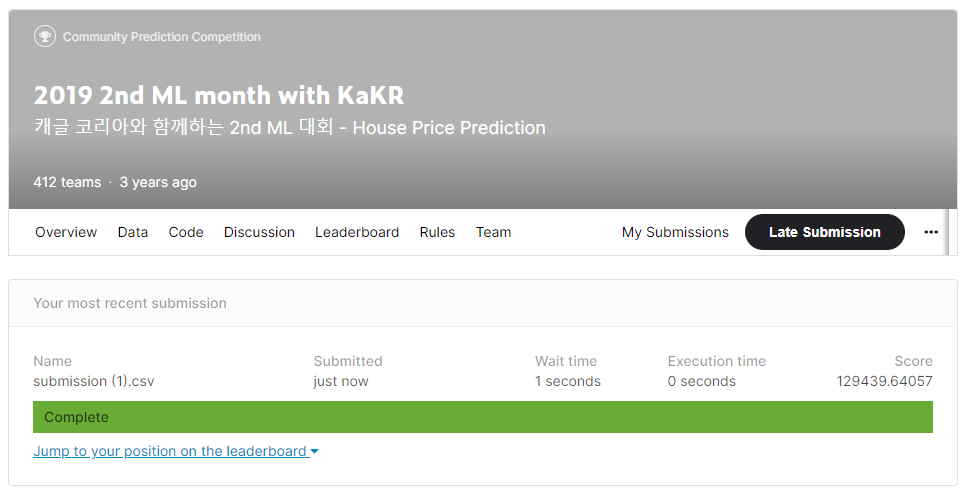

###Score2.
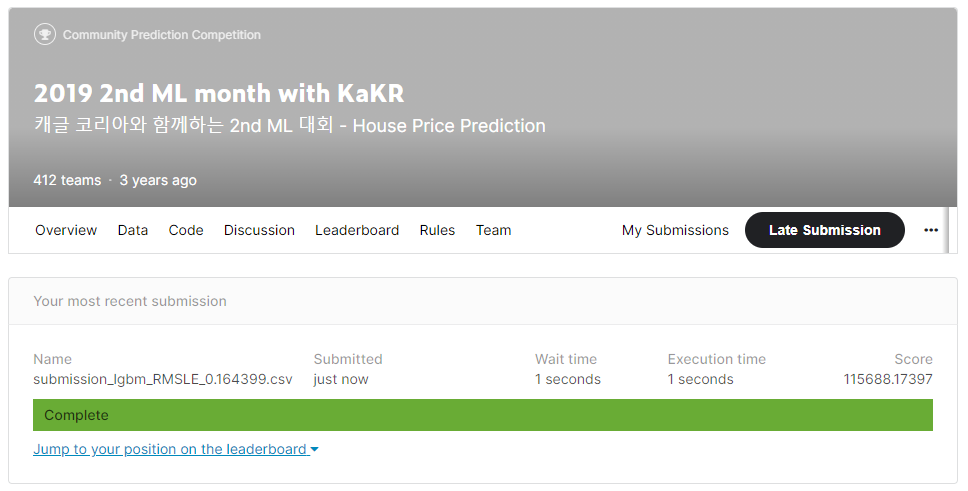


---
#**1. 데이터 준비**

##(1) data 살펴보기
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 가장 가까운 15개 집의 주거 공간의 평방 피트의 평균
21. sqft_lot15 : 가장 가까운 15개 집의 부지의 평방 피트의 평균2. 

##(2) 필요한 폴더 및 라이브러리 준비

In [1]:
! mkdir -p /content/aiffel/kaggle_kakr_housing/data

In [23]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# matplotlib 시각화
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

np.random.seed(111)

print('Ok, good!')

Ok, good!


##(3) 데이터 가져오기

In [24]:
#data load
data_dir = '/content/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')        # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)

#데이터 불러오기
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

/content/aiffel/kaggle_kakr_housing/data/train.csv
/content/aiffel/kaggle_kakr_housing/data/test.csv
train data dim : (15035, 21)
test data dim : (6468, 20)


##(4) 컬럼 이해하기
- date 컬럼을 보면 불필요하게 길게 되어 있음을 볼 수 있다.   
  따라서 슬라이싱을 통해 int 로 변환 필요

In [25]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- 주 타겟이 되는 price 컬럼을 시각화해보면 왼쪽으로 상당히 치우쳐있다.   
  따라서 이 부분을 좀 더 고르게 분포할 수 있게 정규화 해주겠다.

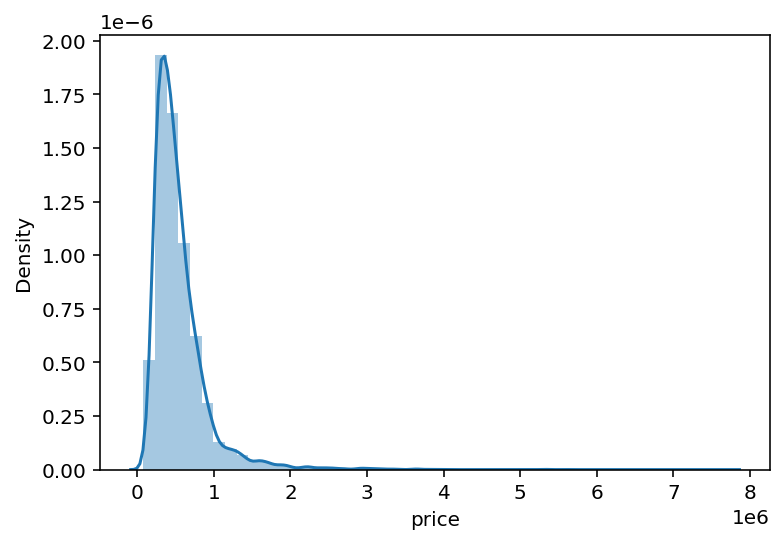

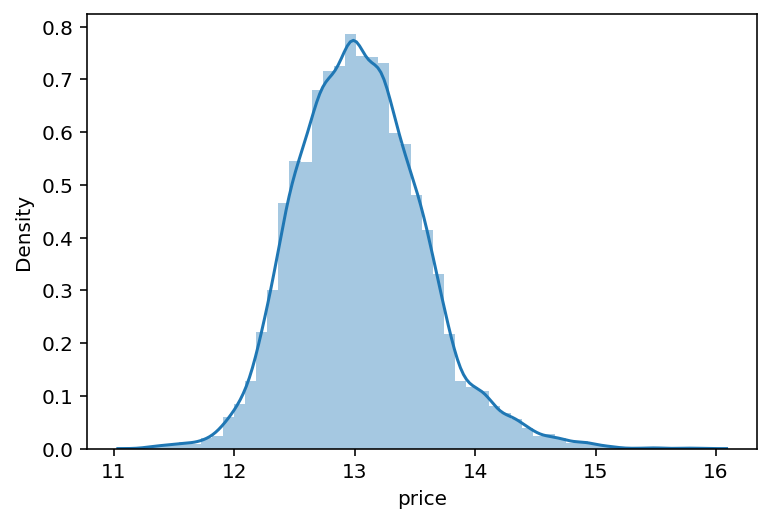

In [26]:
sns.distplot(train['price'])
train['price'] = np.log1p(train['price'])

#histogram
f, ax = plt.subplots()
sns.distplot(train['price'])

##(5) 상관관계 살펴보기

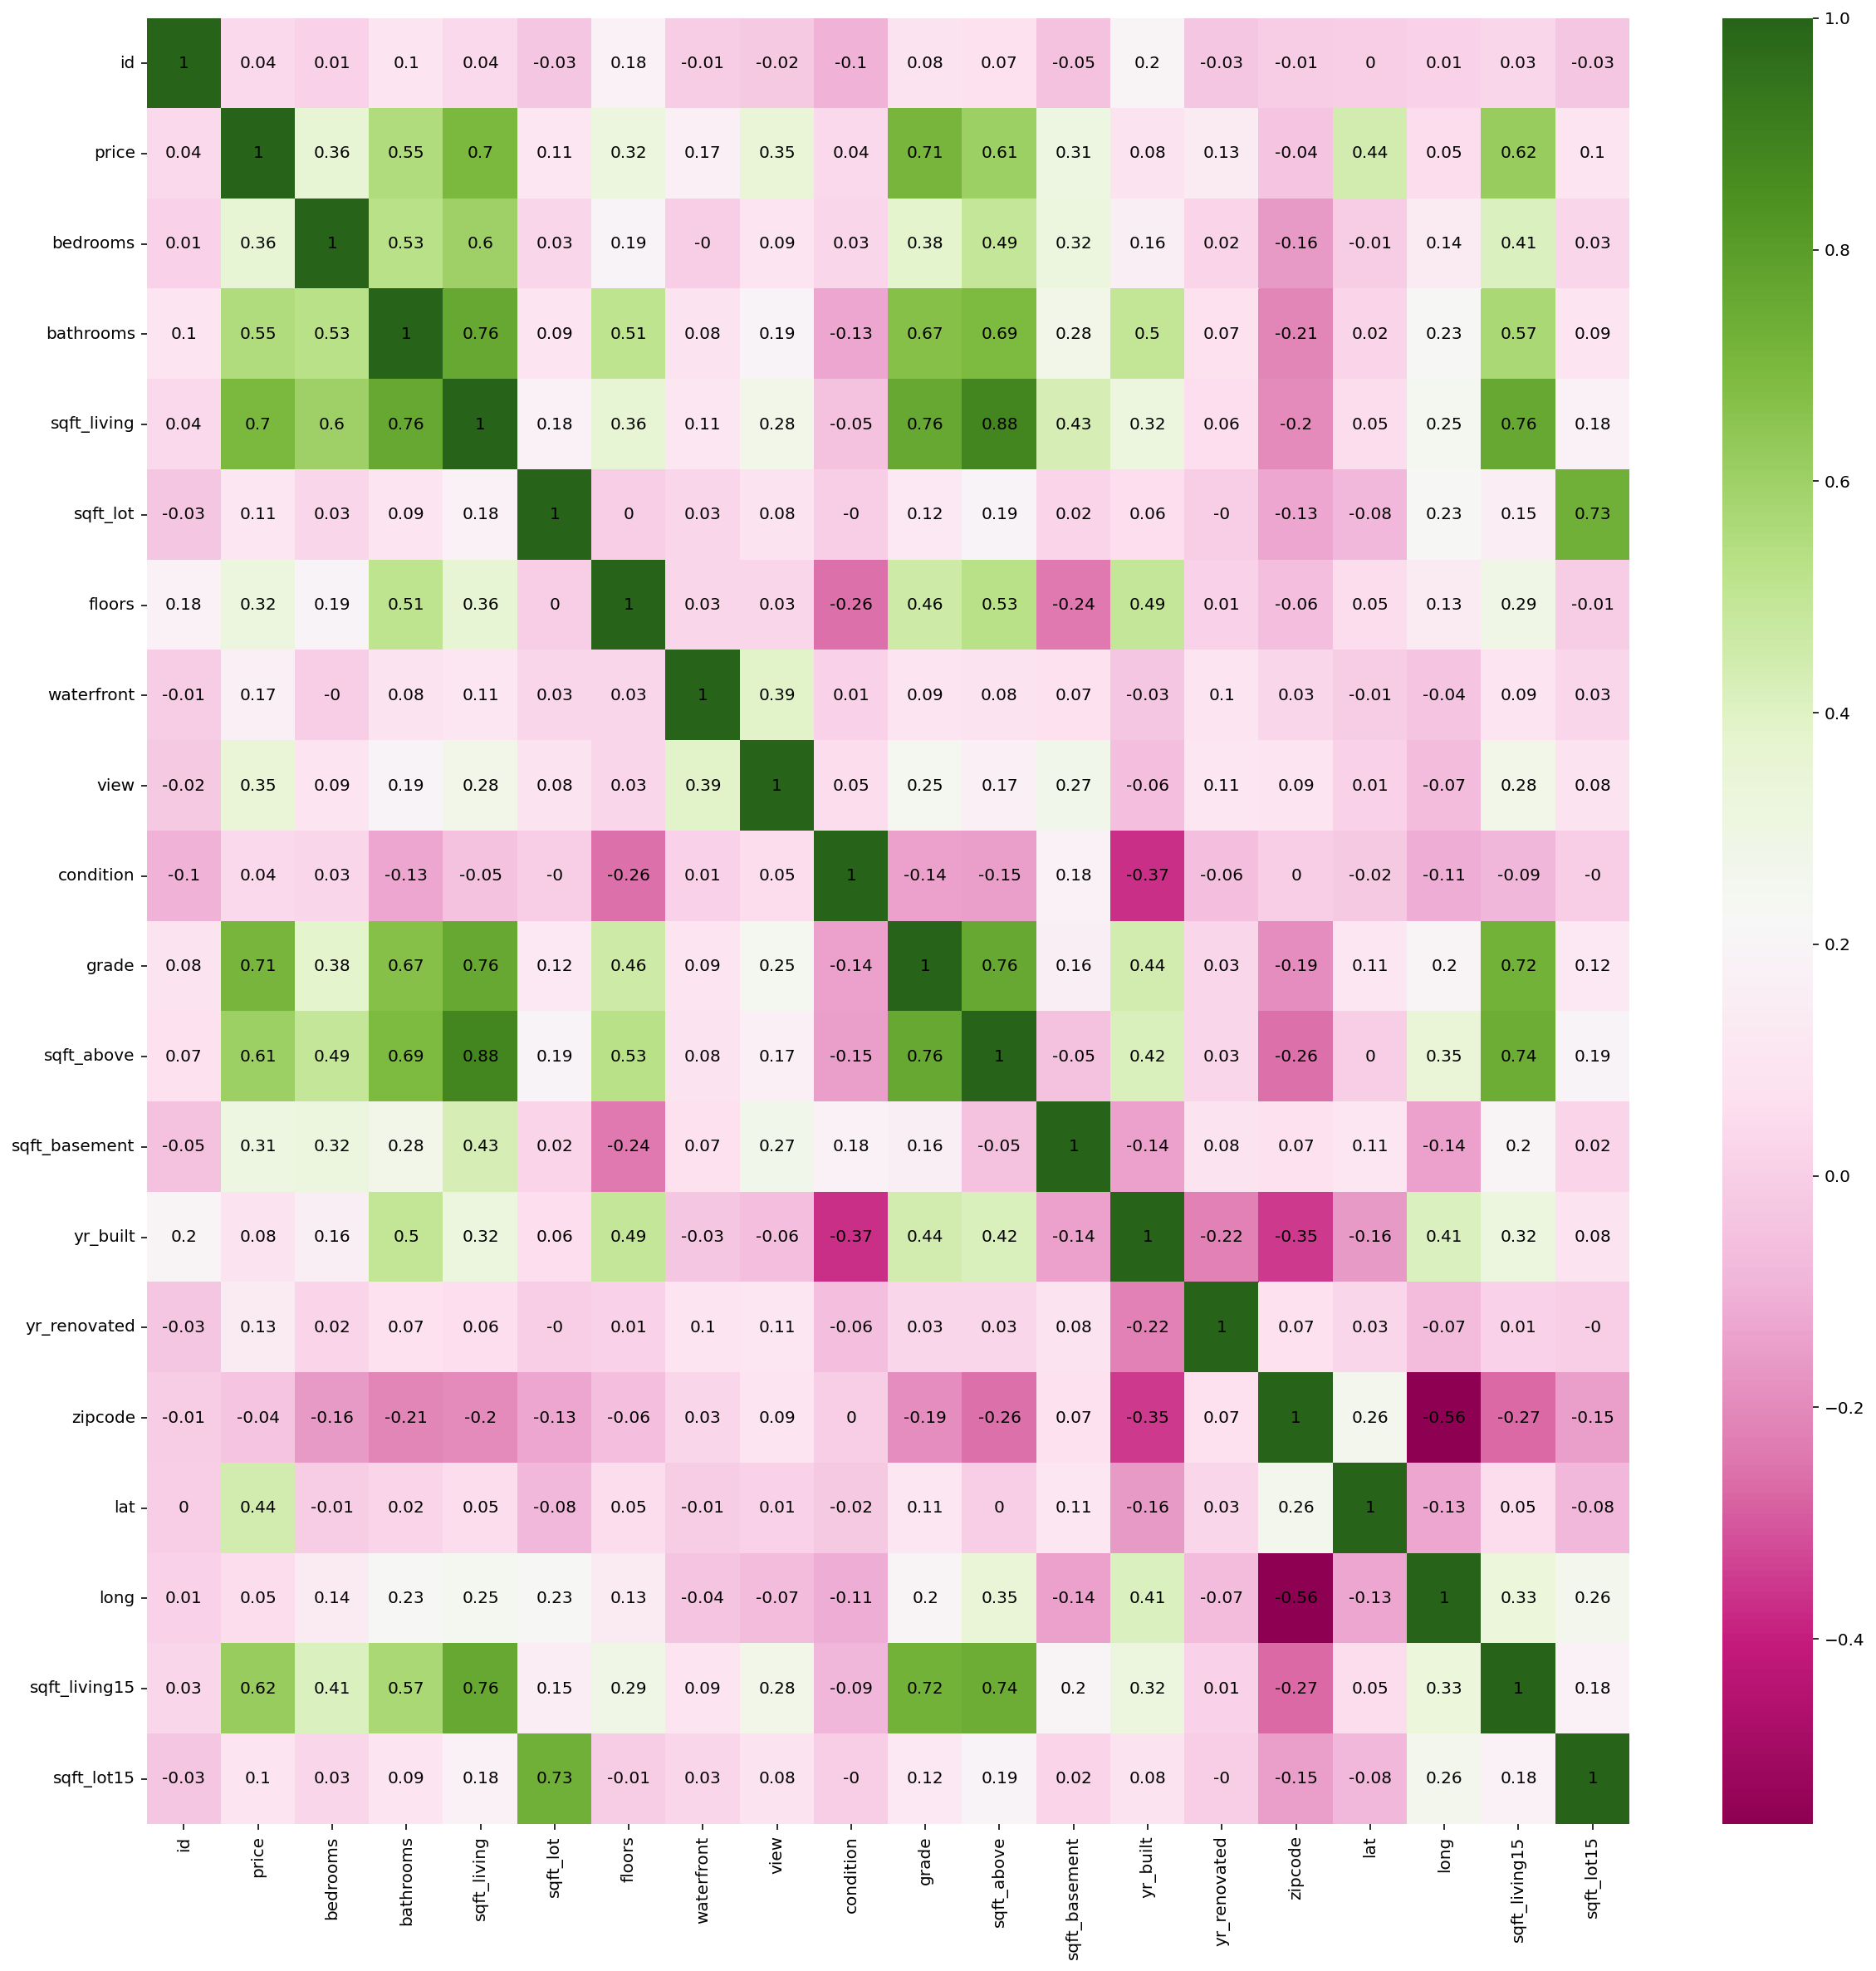

In [6]:
corr_df = train.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)

plt.figure(figsize=(20,20))   #아 이부분이 아래로 내려가면 크기 변경에 영향을 못 주는구나..!
ax = sns.heatmap(corr_df, annot=True, annot_kws=dict(color='black'), cmap='PiYG')   #YlGnBu, RdBu 도 이쁨
plt.show()

In [7]:
# price에 대한 다른 변수들의 상관관계
co = pd.DataFrame(corr_df["price"].sort_values(ascending = False))  #Price에 대한 다른 변수 수치 뽑기, 내림차순 정렬
co.style.background_gradient(cmap='viridis')    #스타일 지정해서 범위 별 색깔 입히기

,price
price,1.000000
grade,0.710000
sqft_living,0.700000
sqft_living15,0.620000
sqft_above,0.610000
bathrooms,0.550000
lat,0.440000
bedrooms,0.360000
view,0.350000
floors,0.320000


###**❗ 고민 ❗**
- 상위 5개 요소(초록색) 구간이 집값에 가장 큰 영향을 주는 것 같다.   
- 사실상 나머지 변수들은 영향력이 미미한데 개인적으로 yr_built나 yr_renovated 등이 왜 상관관계가 낮고, zipcode는 왜 -값을 가지는지 이해가 잘 되지 않는다.   
- view~foolrs(파란색) 구간도 어느 정도 집값에 영향을 미칠 것 같긴 하지만 우선은 상위 5개 변수 위주로 정제를 시도해보겠다. 
- 상위 5개 요소값들에 대해서는 이상치 확인을 통해 이상치가 있으면 제거해주도록 하겠다.   

   

---



#**2. 변수 시각화**
- 위 표를 통해서 price는 grade, sqft_living, sqft_living15, sqft_above,bathroom 순대로 상관관계가 높음을 알 수 있다.      
- 각 변수별로 시각화를 통해 좀 더 파악해보겠다.
- sqft_living는 boxplot을 적용했더니 예상했던 그래프와 상당히 다른 모습이 나와 regplot를 적용시켜주겠다.   
- 그래프의 종류 중 scatter(산점도)와 histogram(분포)를 동시에 그려주는  jointplot이 유용할 것 같았으나 생각보다 아래 데이터들을 직관적으로 파악하기엔 적합하지 않았다.


##(1) grade : King County grading 시스템 기준으로 매긴 집의 등급
- boxplot을 살펴보면 생각보다 이상치가 많음을 볼 수 있다.
- 그 중에서도 유난히 7, 8, 11의 이상치가 눈에 띈다.
- 3의 경우4~6보다 가격이 높게 나타나는 이상 현상이 있다.
- 3, 7, 8, 11의 데이터를 확인하고 이상치 제거를 해주도록 하겠다.

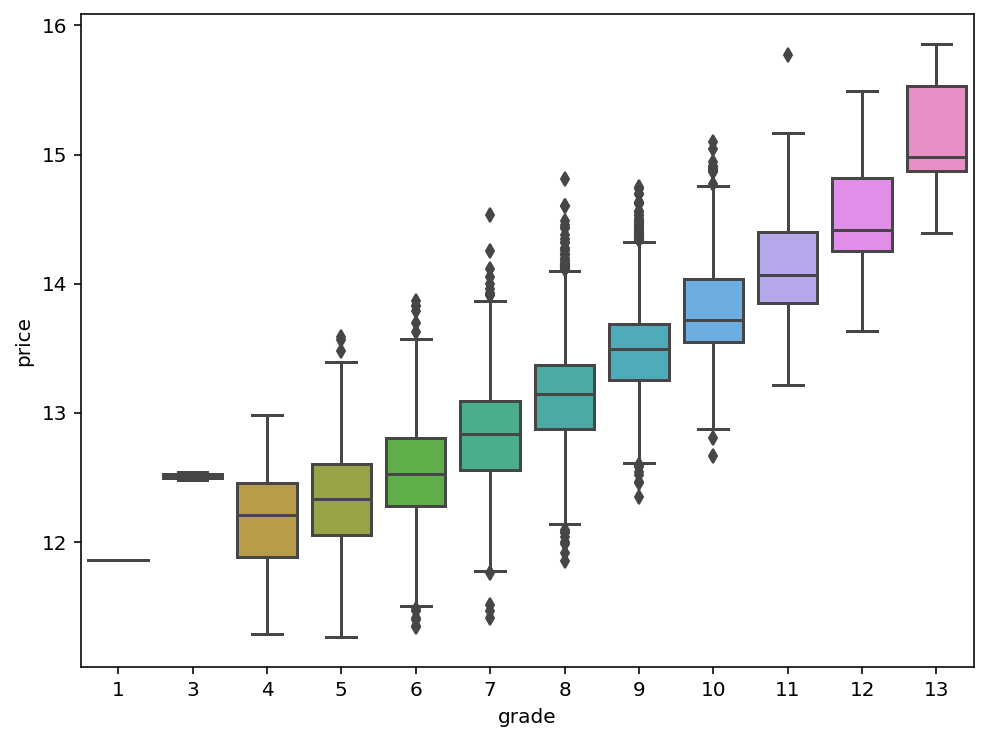

In [8]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

## (2) sqft_living : 주거 공간의 평방 피트
- 전반적으로 범위 내 잘 분포되어 있다.
- sqft_living 대략 13000 이상에서 이상치가 하나 보인다.
- 데이터 확인을 통해 이상치 제거를 결정하겠다.

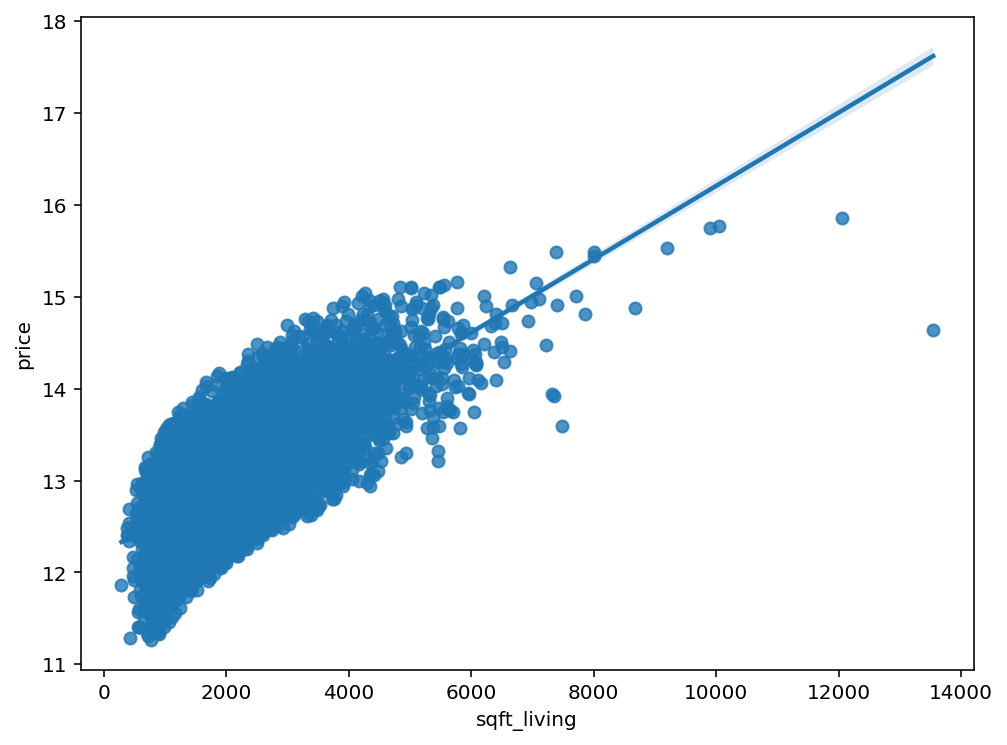

In [9]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

## (3) sqft_living15 : 가장 가까운 15개 집의 주거 공간의 평방 피트의 평균
- 전반적으로 고르다.
- sqft_living15 4000쯤에서 유난히 price가 높은 데이터가 2개 정도 보이는데, 데이터 확인 후 이상치 판단을 하겠다.
- sqft_living와 sqft_living15 를 비교하는 것도 굉장히 의미있는 시도일 것 같다.

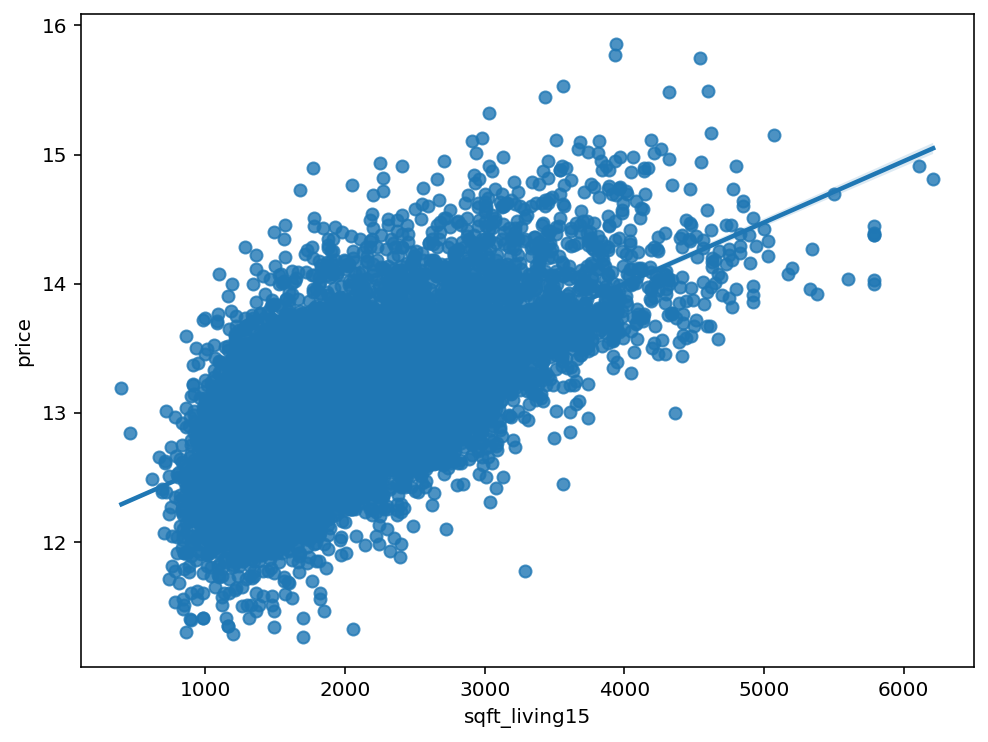

In [10]:
data = pd.concat([train['price'], train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

##(4) sqft_above : 지하실을 제외한 평방 피트
- 이상치가 없다고 판단한다.

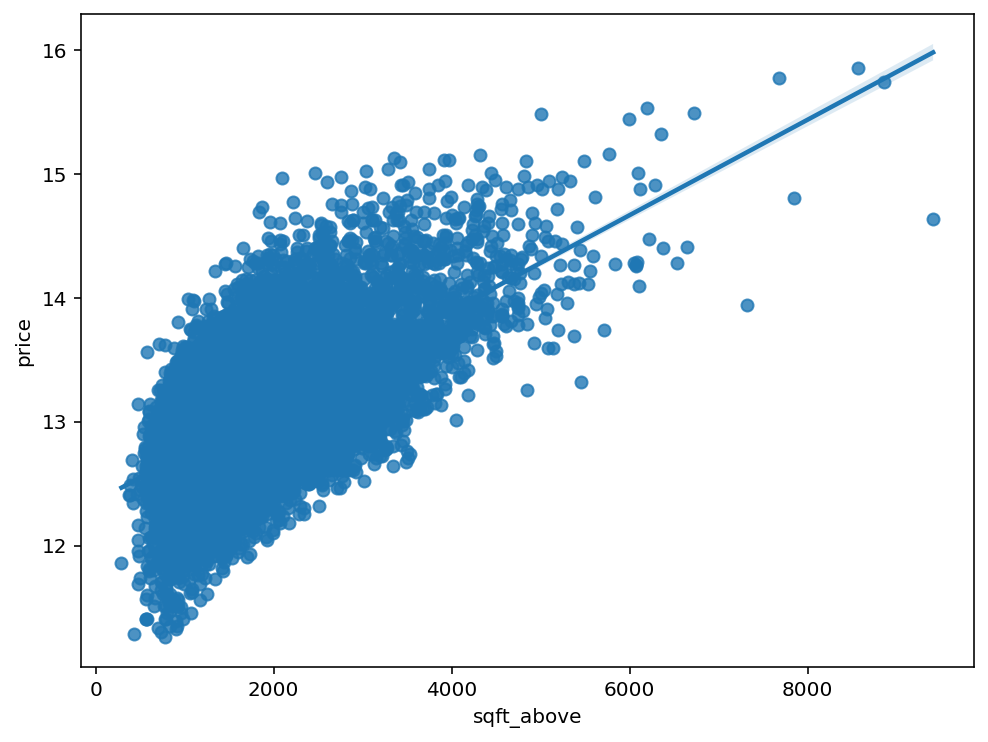

In [11]:
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

##(5) bathrooms : 화장실의 수

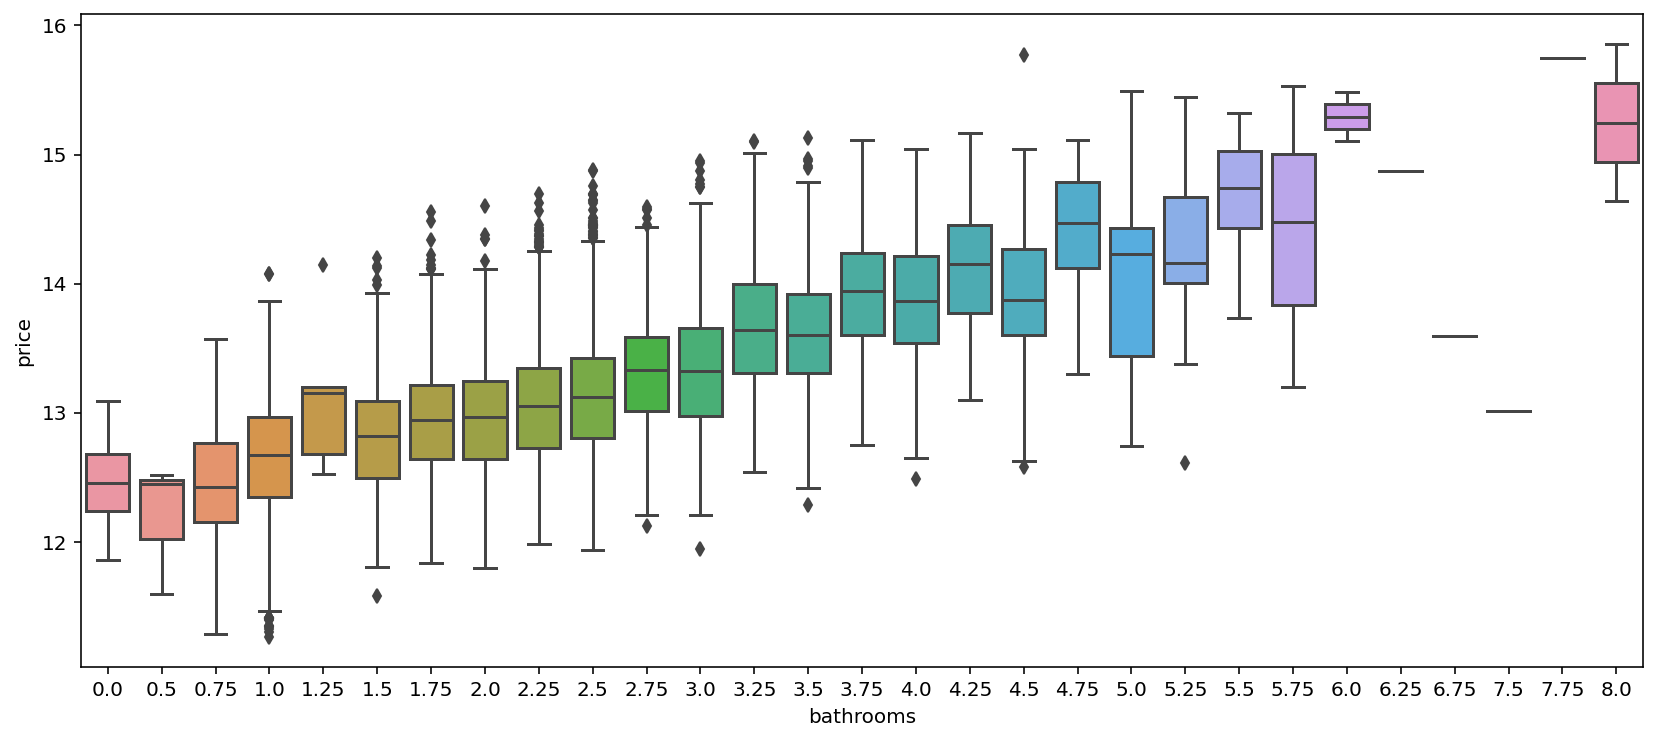

In [12]:
data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

## (6) yr_built : 집을 지은 년도
- 연도별로 보면 집값 추이와 상관관계가 있을 것 같아서 보았다. 
- 집값이 완만한 우상향을 보일 것이라는 내 예측과 달리 1900년대에 지어진 집과 2000년대에 지어진 집의 price엔 큰 차이가 없다.
- 다만 이상치의 분포가 굉장히 넓은 것을 볼 수 있는데 이는 다른 변수들의 영향이 큰 것 같다.
- price와 상관관계가 낮은데는 이유가 있었구나....

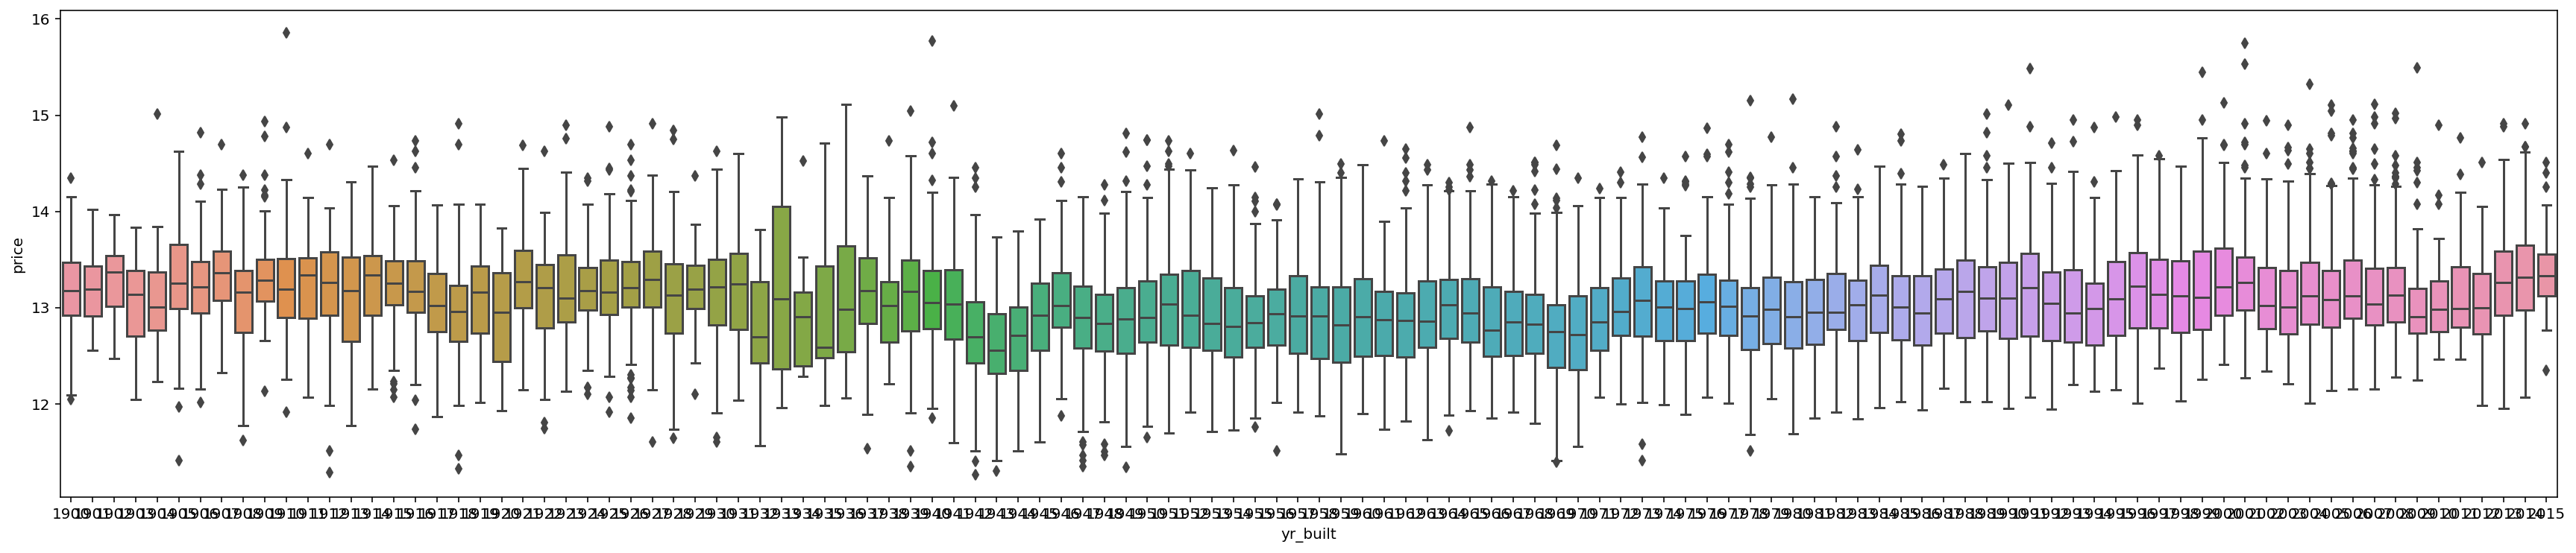

In [13]:
data = pd.concat([train['price'], train['yr_built']], axis=1)
f, ax = plt.subplots(figsize=(30, 6))
fig = sns.boxplot(x='yr_built', y="price", data=data)

## (7) yr_renovated : 집을 재건축한 년도
- 집을 지은 연도와 price에 큰 차이는 없어도 재건축이 가격에 영향을 주지 않았을까?
- yr_buit와 겹쳐볼 수 있는 그래프도 있으면 유용할 것 같다.

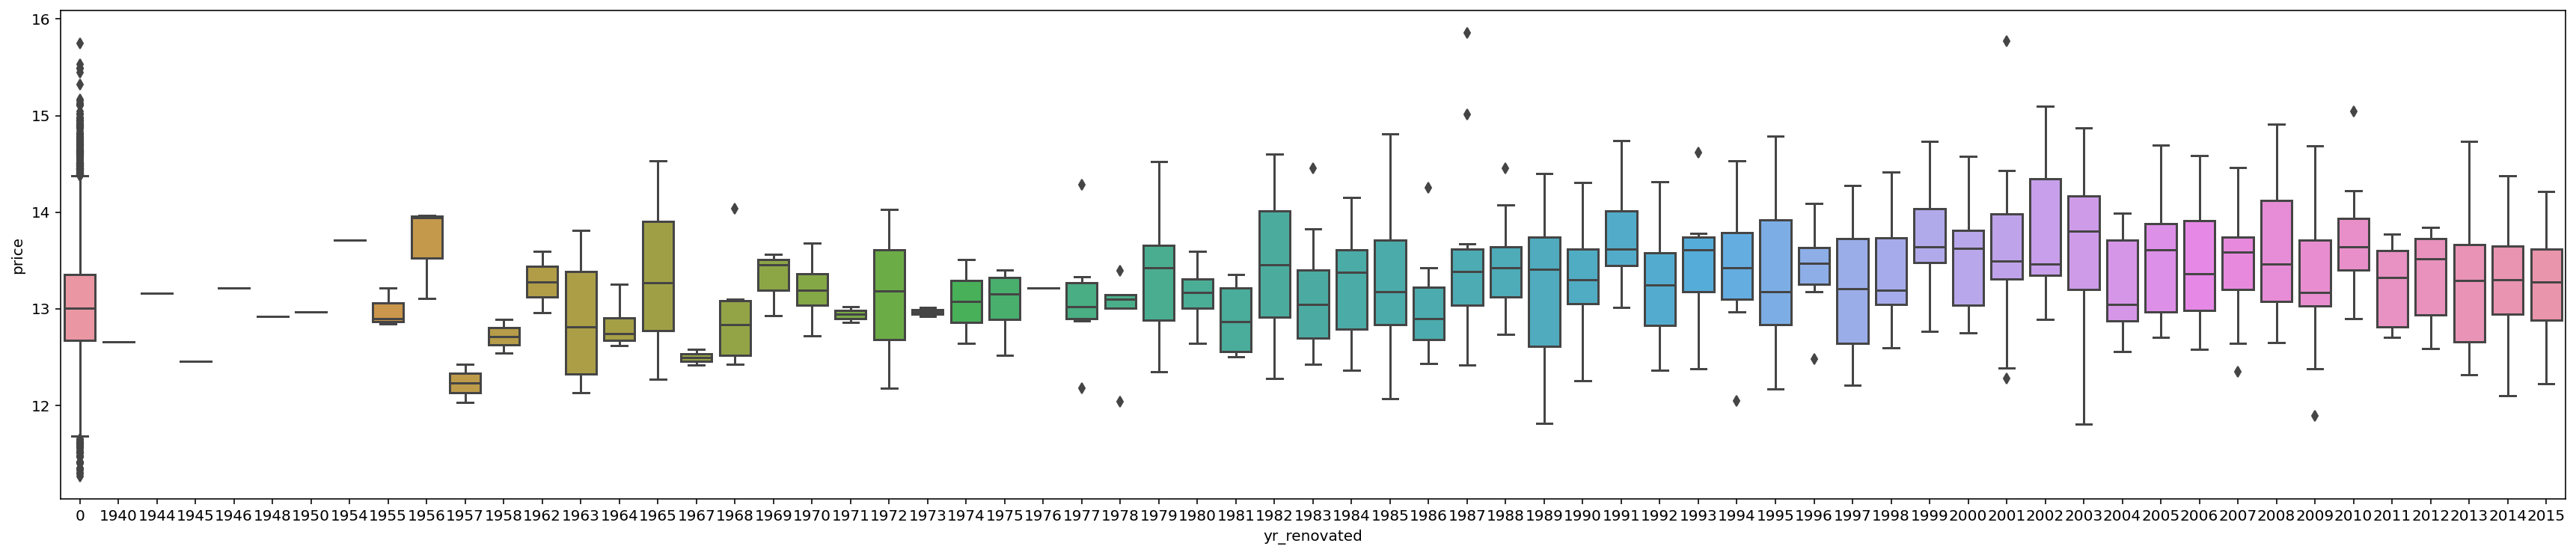

In [14]:
data = pd.concat([train['price'], train['yr_renovated']], axis=1)
f, ax = plt.subplots(figsize=(30, 6))
fig = sns.boxplot(x='yr_renovated', y="price", data=data)

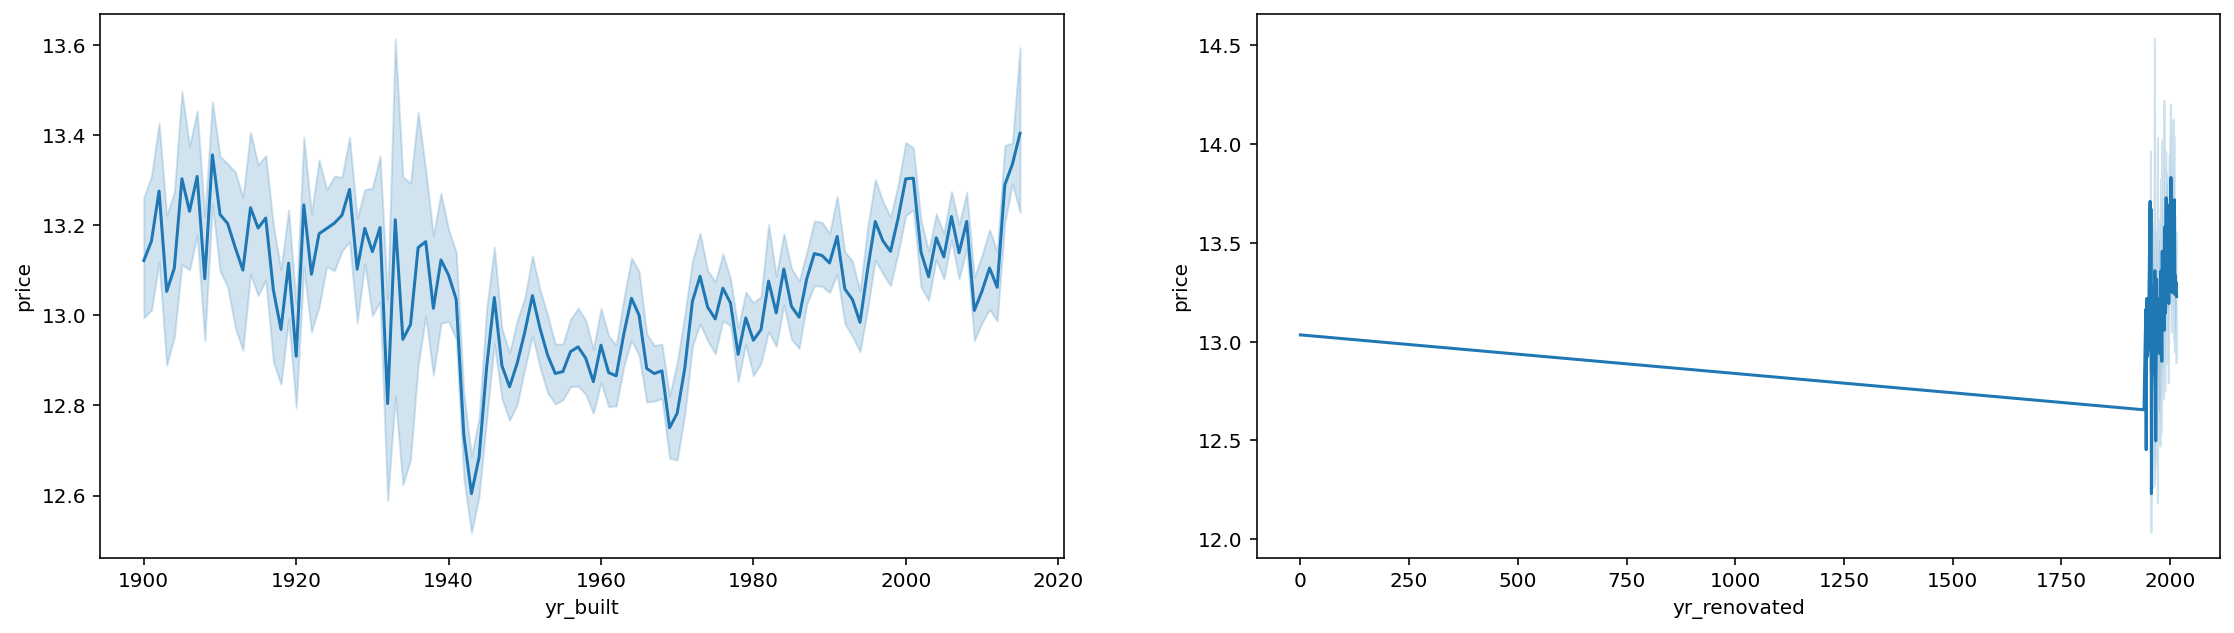

In [15]:
#yr_built와 yr_renovated 비교
# 시각화 
f, ax = plt.subplots(1, 2, figsize=(19, 5))
sns.lineplot(x='yr_built', y= 'price', data=train, ax=ax[0])
sns.lineplot(x='yr_renovated', y= 'price', data=train, ax=ax[1])

- 재건축을 현대 들어서 시작했으면 재건축 일자 기준으로 잘라서 사용하려 했으나,   
생각보다 분포가 다양해서 그대로 두기로 했다.
- 그래프와 정보를 파악해보면, 재건축은 1940년부터 시작하였다.
- 신기하게도 집값 또한 ~1940까지는 점차 하락세였다가 1940부터는 우상향 형식을 띈다.
- 1940년도 자료부터 사용을 해도 괜찮을 것 같다.

In [16]:
#New_yr_renovated = train.sorted(yr_renovated)
#train.groupby(['yr_renovated', 'price']).mean()
#train.yr_renovated
#train['yr_renovated'].sort_values(asscending=False)
reno = train.groupby('yr_renovated')
reno.size()

yr_renovated
0       14404
1940        1
1944        1
1945        1
1946        1
        ...  
2011        8
2012        8
2013       28
2014       71
2015       11
Length: 65, dtype: int64

## (8) zipcode : 우편번호
- zipcode를 price 상관관계에서 보면 (-)이다.
- 아무래도 이상한 결과가 나온 것 같아 이를 분석해보아야 할 것 같다.
- 분석법에 아는 것이 없었기에 구글링 도움을 받아 실행해본다.
- `groupby()` : price의 평균값을 구할 수 있음
- 대충만 봐도 zipcode에 따라 가격이 유사하다는 사실을 알 수 있다.

In [17]:
train.groupby(['zipcode', 'price']).mean()

id  bedrooms  ...  sqft_living15  sqft_lot15
zipcode price                         ...                           
98001   11.512935   5834.0       2.0  ...         1403.0     13612.5
        11.732069   7002.0       2.0  ...         1100.0      7300.0
        11.842236   6068.0       3.0  ...         1530.0     18694.0
        11.944714  11144.0       3.0  ...         1410.0      9997.0
        11.976666  13427.0       3.0  ...         1530.0      9997.0
...                    ...       ...  ...            ...         ...
98199   14.508158   9258.0       4.0  ...         3070.0      7500.0
        14.582141  10570.0       4.0  ...         3280.0      5915.0
        14.585619  13424.0       3.0  ...         4120.0      8620.0
        14.843343   8098.0       5.0  ...         2920.0      8609.0
        14.978662   5560.0       6.0  ...         3130.0      6477.0

[11200 rows x 18 columns]

In [20]:
len(train['zipcode'].unique())

70

- 우편번호는 총 70임을 알 수 있다.
- 즉, 70 묶음 별 price가 비슷하지 않을까 추정할 수 있다.

In [ ]:
#EUN YONG님 코드 참고 groupby(['zipcode', 'price'])
#zip_level
a = train[['zipcode', 'price']].groupby('zipcode').mean()
label = [j+1 for j in range(27)]
a['zip_level'] = pd.cut(a.price, bins=27, labels=label)
a = a.drop(['price'], axis=1)

trainf = train.merge(a, on='zipcode', how='left')
test = test.merge(a, on='zipcode', how='left')
train.zip_level = train.zip_level.astype(int)
test.zip_level = test.zip_level.astype(int)

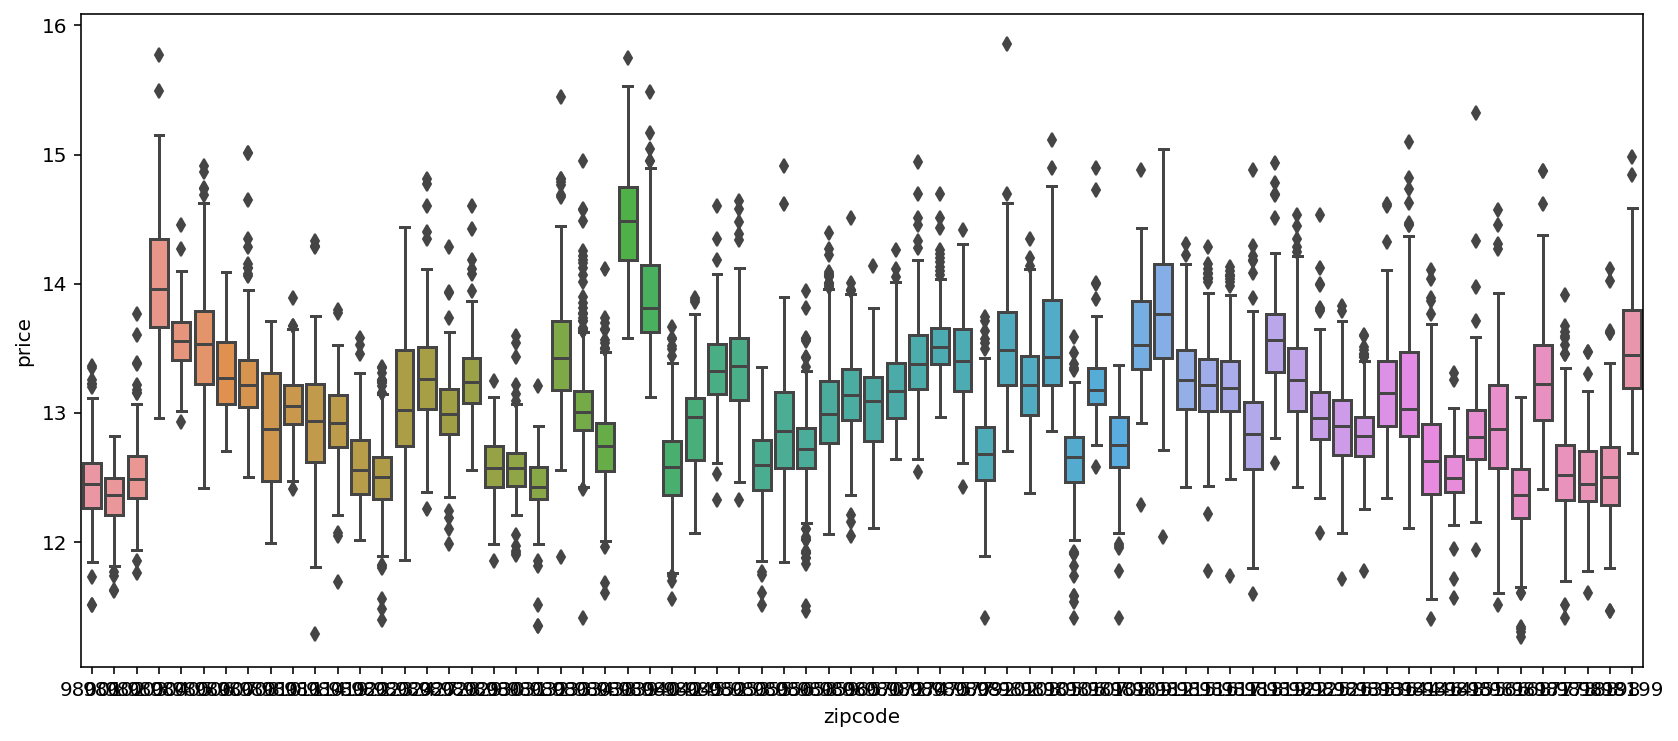

In [22]:
data = pd.concat([train['price'], train['zipcode']], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x='zipcode', y="price", data=data)

##(9) sqft_living와 sqft_living15

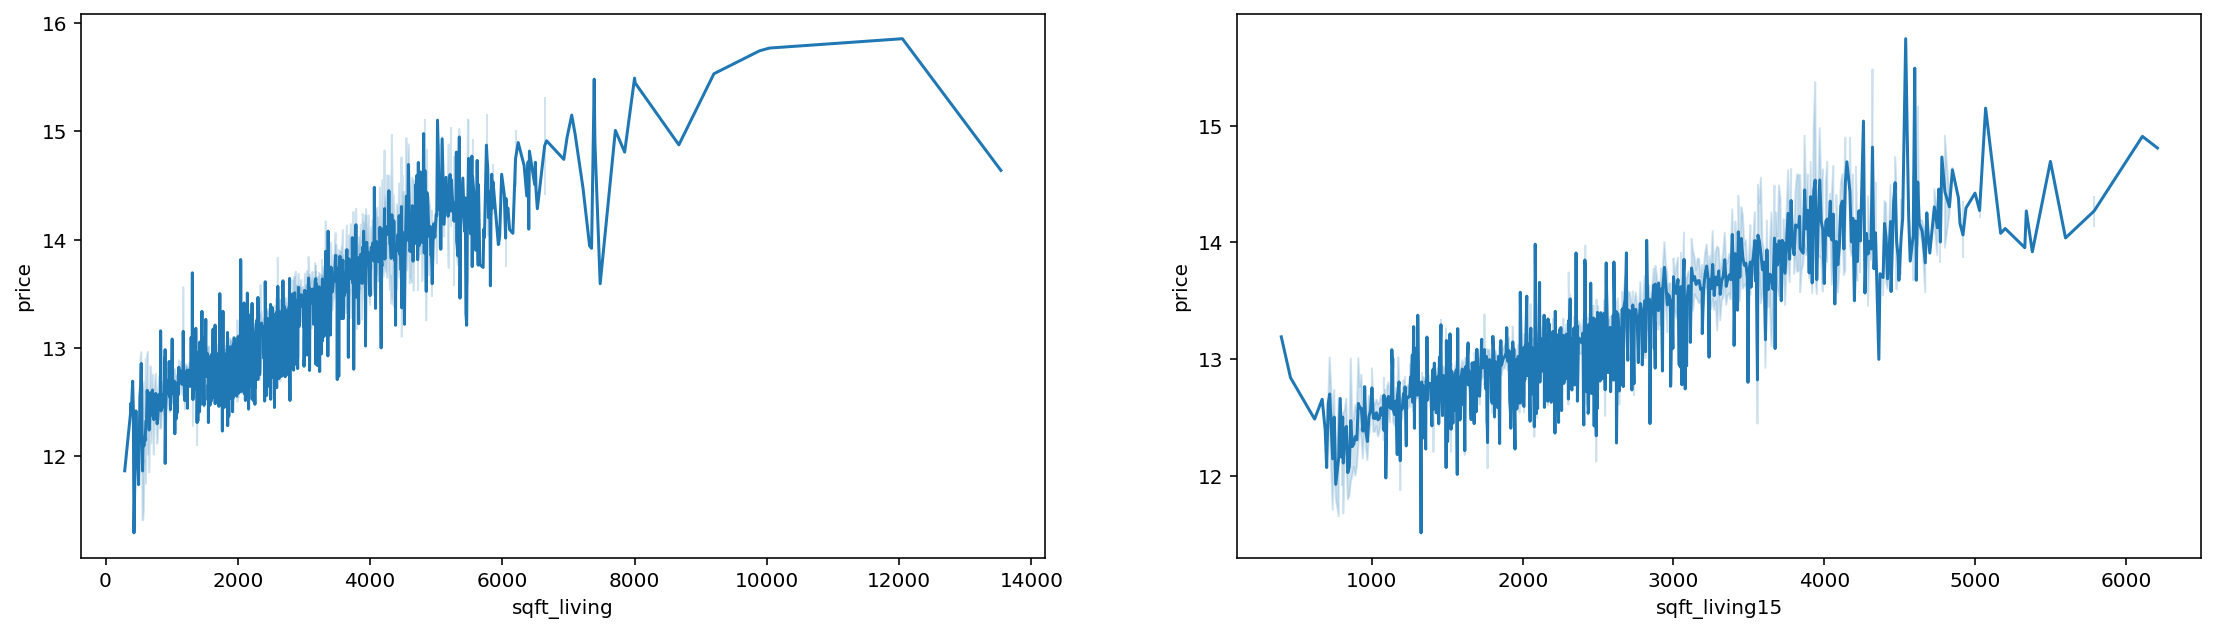

In [4]:
f, ax = plt.subplots(1, 2, figsize=(19, 5))
sns.lineplot(x='sqft_living', y= 'price', data=train, ax=ax[0])
sns.lineplot(x='sqft_living15', y= 'price', data=train, ax=ax[1])

둘 다 비슷한 그래프 형태의 띄긴하나 sqft_living15가 근방 15개의 평균 수치로
좀 더 고른 데이터를 보여주는 것 같다.   
특히나 sqft_living는 12000 기점에서 갑자기 price가 뚝 떨어지는데   
이부분에 있어서는 sqft_living를 제거하고 sqft_living15사용하는 것으로 하겠다.

##(10)sqft_lot과 sqft_lot15

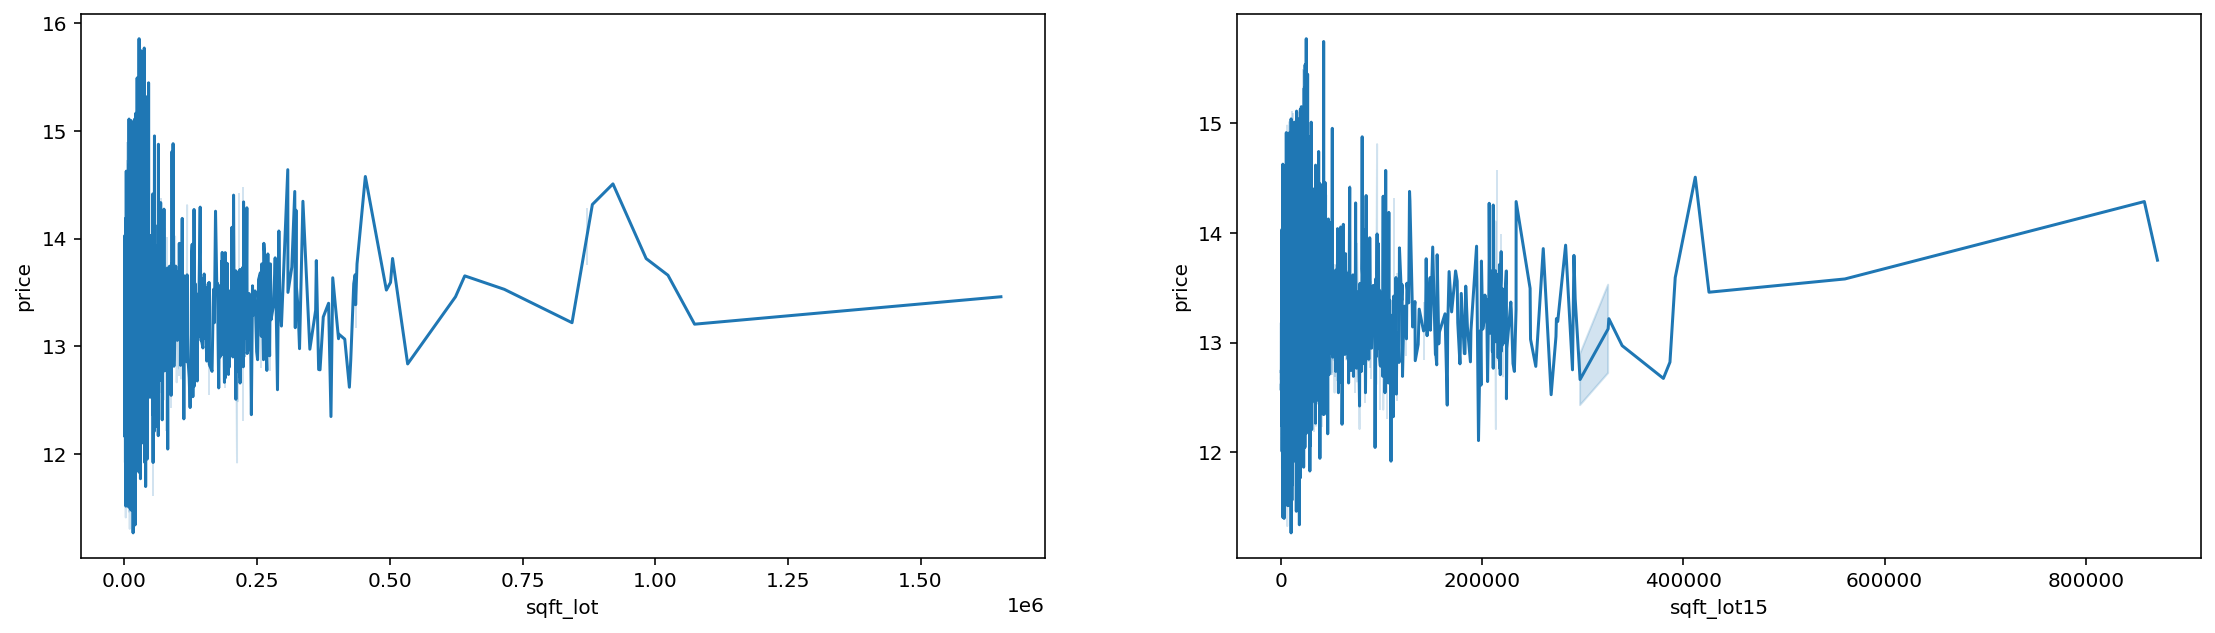

In [5]:
f, ax = plt.subplots(1, 2, figsize=(19, 5))
sns.lineplot(x='sqft_lot', y= 'price', data=train, ax=ax[0])
sns.lineplot(x='sqft_lot15', y= 'price', data=train, ax=ax[1])

#**3. 데이터 정규화**
##(1) 결측치 제거
- 결측치가 존재하면 흰색 막대가 보인다.   
  하지만 아래 그래프에선 결측치가 보이지 않으므로, 결측치 제거는 생략하도록 한다.

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


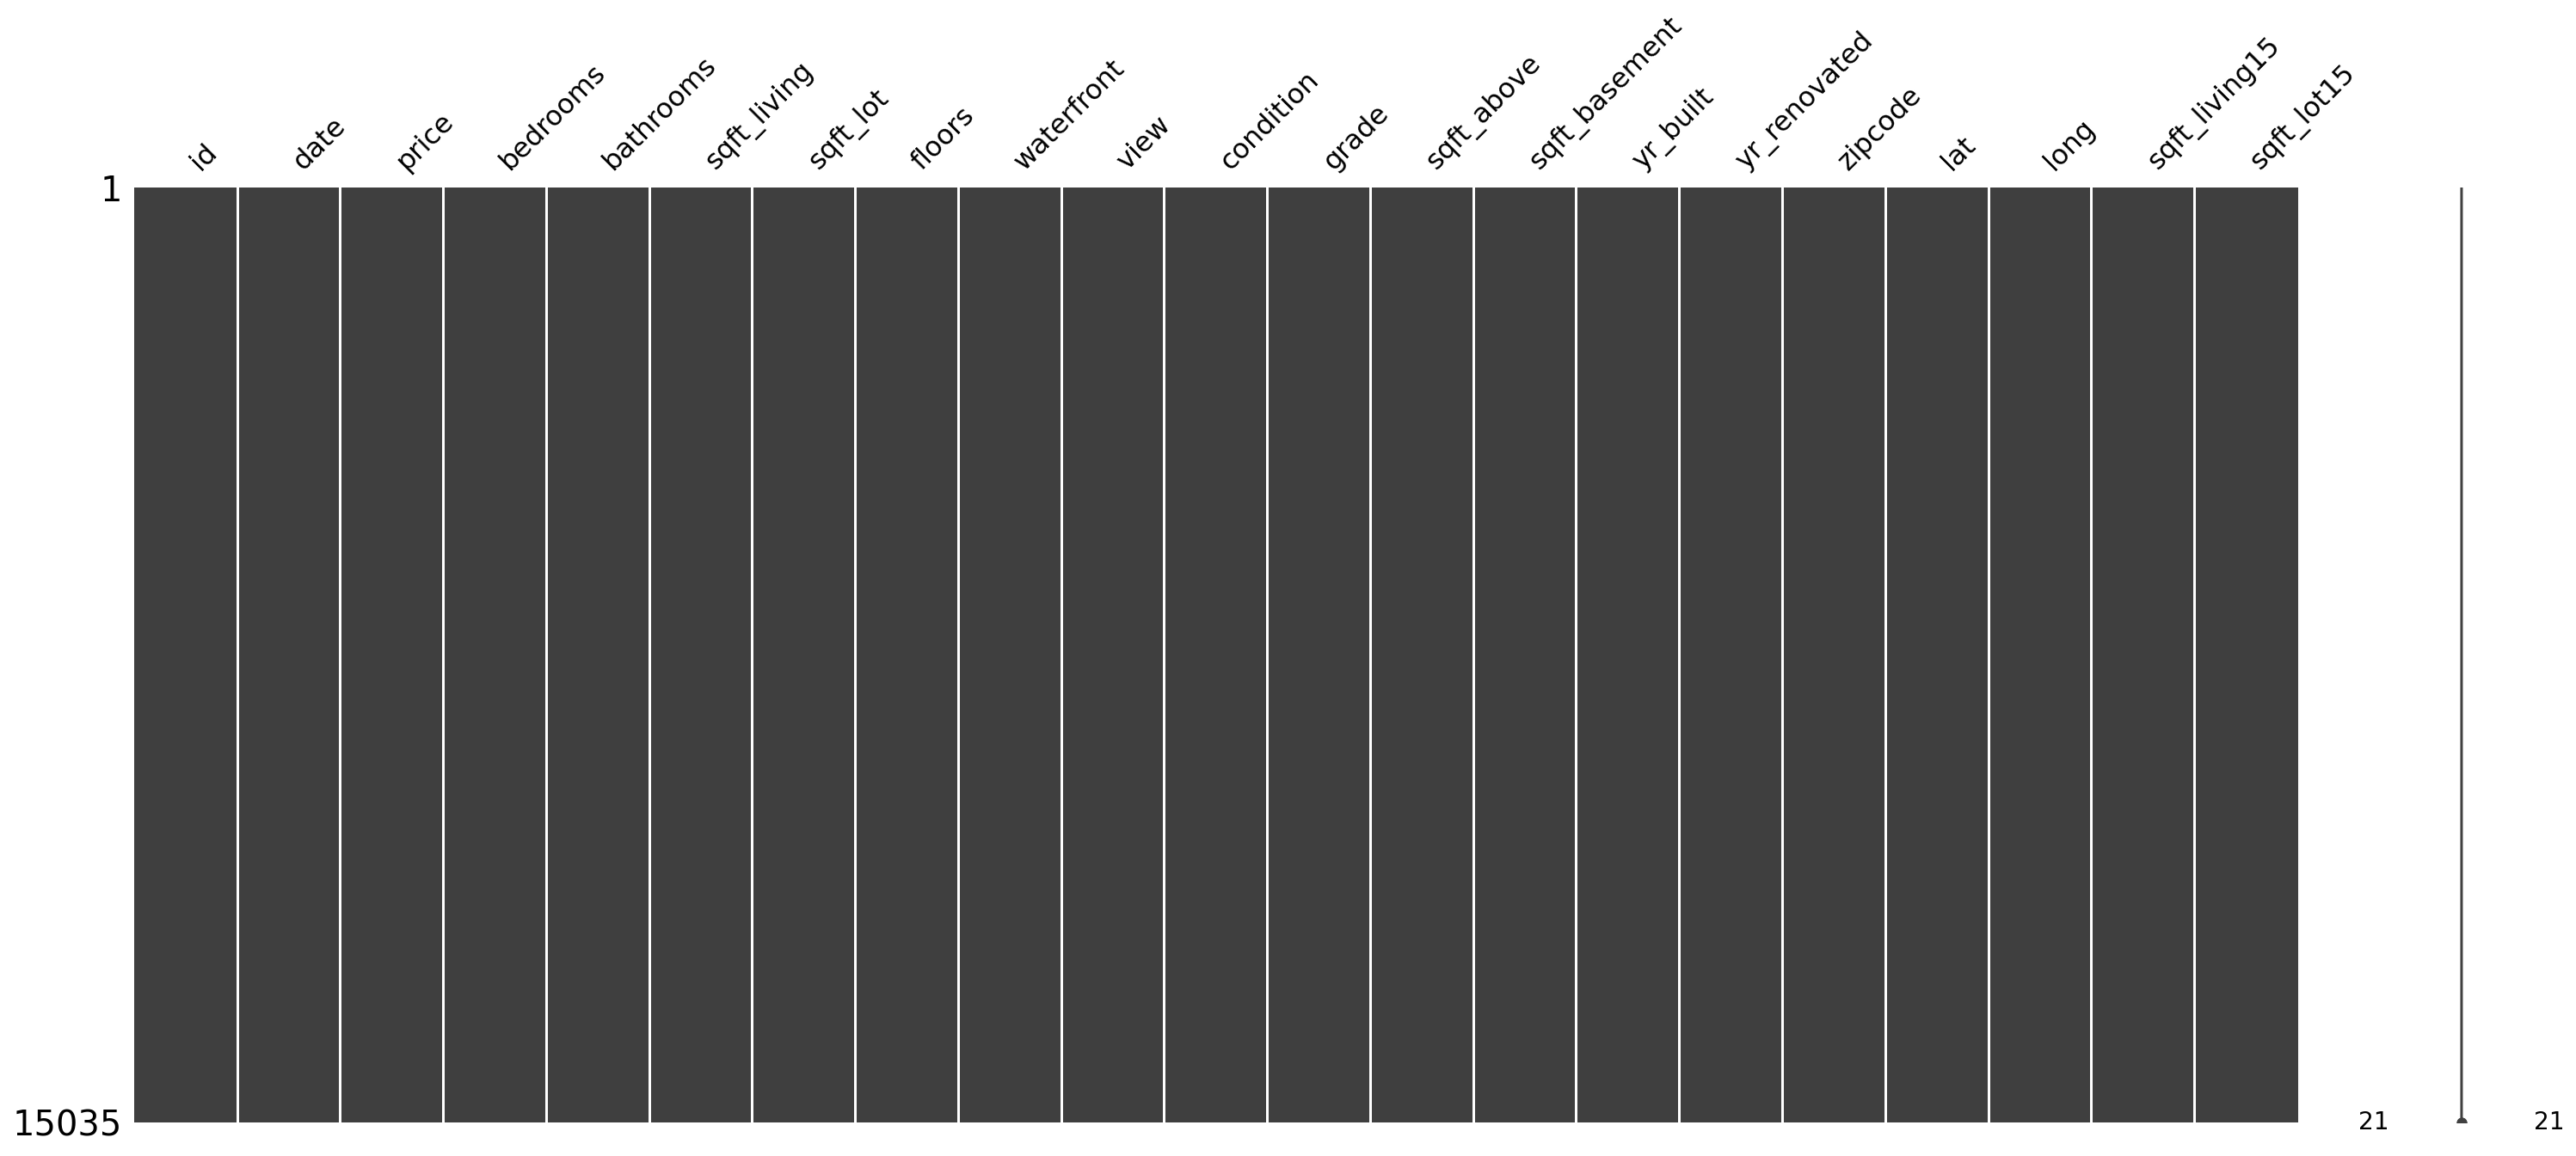

In [23]:
msno.matrix(train)
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

##(2) 이상치 제거
###  (2-1) grade : King County grading 시스템 기준으로 매긴 집의 등급

In [ ]:
# 3등급일때 이상치
train.loc[train['grade'] == 3]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [ ]:
# 7등급일때 이상치
train.loc[(train['price']>14) & (train['grade'] == 7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
647,647,20140604T000000,14.054528,5,2.50,3200,17204,1.0,0,0,3,7,2160,1040,1952,0,98004,47.6209,-122.222,4090,15732
8148,8148,20150430T000000,14.250535,4,2.25,2640,3000,2.0,0,0,3,7,2080,560,1908,0,98109,47.6313,-122.344,1910,3000
12346,12346,20150115T000000,14.533351,4,3.25,3580,19989,1.5,1,4,4,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389
12457,12457,20140801T000000,14.115616,3,2.00,2070,9600,1.0,0,1,3,7,1590,480,1946,0,98039,47.6160,-122.239,3000,16215


In [ ]:
# 8등급일때 이상치
train.loc[(train['price']>14.5) & (train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
983,983,20150511T000000,14.603968,5,4.25,4640,22703,2.0,1,4,5,8,2860,1780,1952,0,98052,47.6393,-122.097,3140,14200
7173,7173,20140813T000000,14.808763,5,4.00,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295
10037,10037,20140825T000000,14.603968,3,2.00,3570,30456,1.0,0,1,3,8,2070,1500,1946,1982,98039,47.6413,-122.240,3570,27418


In [ ]:
#11등급일때 이상치
train.loc[(train['price']>15) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1499,1499,20141114T000000,15.163584,4,4.25,5770,21300,2.0,1,4,4,11,5770,0,1980,0,98040,47.5850,-122.222,4620,22748
2775,2775,20140611T000000,15.770310,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
4598,4598,20150421T000000,15.110238,6,4.75,5480,19401,1.5,1,4,5,11,3910,1570,1936,0,98105,47.6515,-122.277,3510,15810
7297,7297,20150508T000000,15.039286,4,4.00,4260,11765,2.0,0,0,3,11,3280,980,1939,2010,98112,47.6380,-122.288,4260,10408
9814,9814,20140904T000000,15.009433,5,4.75,6200,13873,2.0,1,4,4,11,4440,1760,1989,0,98008,47.6050,-122.112,2940,13525
10645,10645,20140911T000000,15.107742,4,3.25,4830,22257,2.0,1,4,4,11,4830,0,1990,0,98039,47.6409,-122.241,3820,25582
12646,12646,20141230T000000,15.009433,3,3.25,4220,41300,1.0,1,4,4,11,2460,1760,1958,1987,98008,47.6083,-122.110,3810,30401
14231,14231,20150402T000000,15.022978,5,3.75,5350,15360,1.0,0,1,3,11,3040,2310,2008,0,98004,47.6480,-122.218,3740,15940


In [6]:
##이상치 제거

train = train.loc[train['id']!=201502]
train = train.loc[train['id']!=201411]
train = train.loc[train['id']!=201504]
train = train.loc[train['id']!=983]

###  (2-2) sqft_living : 주거 공간의 평방 피트

In [ ]:
# 130000보다 큰 경우 확인
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [7]:
train = train[train['id'] != 8912]

###  (2-3) sqft_living15 : 가장 가까운 15개 집의 주거 공간의 평방 피트의 평균

In [ ]:
train.loc[(train['sqft_living15'] > 3500) & (train['price'] > 15.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.770310,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
3134,3134,20140804T000000,15.532906,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
5108,5108,20141013T000000,15.856731,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,6469,20140919T000000,15.744856,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


In [8]:
train = train[train['id'] != 6469]
train = train[train['id'] != 5108]

##(3) 컬럼 정리
- 앞서 말한대로 'date' 컬럼의 년/월/일 정보만 사용하기 위해 전처리를 하고 추후에 학습에 문제가 없도록 int 자료형으로 선언해주겠다.
- 위 과정을 생략하고 진행했을 경우 모델링에서 오류가 생긴다.(경험담)
- id 컬럼은 price와 연관없기 때문에 삭제해주겠다.
- price는 y변수에 할당하고 지워주겠다.   
  이때 test셋에는 price가 없으므로 train셋에 대해서만 정리하겠다.

In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [27]:
#date 컬럼 정리
train['date'] = train['date'].apply(lambda i: i[:8]).astype("int")
test['date'] = test['date'].apply(lambda i: i[:8]).astype("int")

#id 컬럼 정리
del train['id']
del test['id']

#price 컬럼 정리
y = train['price']
del train['price']

print("컬럼 정리 완료!")

컬럼 정리 완료!


##(4) 데이터 변환
- 데이터가 한쪽으로 치우쳐지면 왜곡 현상이 일어난다.
- 따라서 데이터 확인 후 다듬어준다.
- 이때 train셋과 test셋 모두 다듬어져야 하기 때문에 데이터셋을 뭉쳤다가 다시 나누도록 하겠다.

In [7]:
print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


In [8]:
train_len = len(train)
plus = pd.concat((train, test), axis=0)

print(len(train))

15035


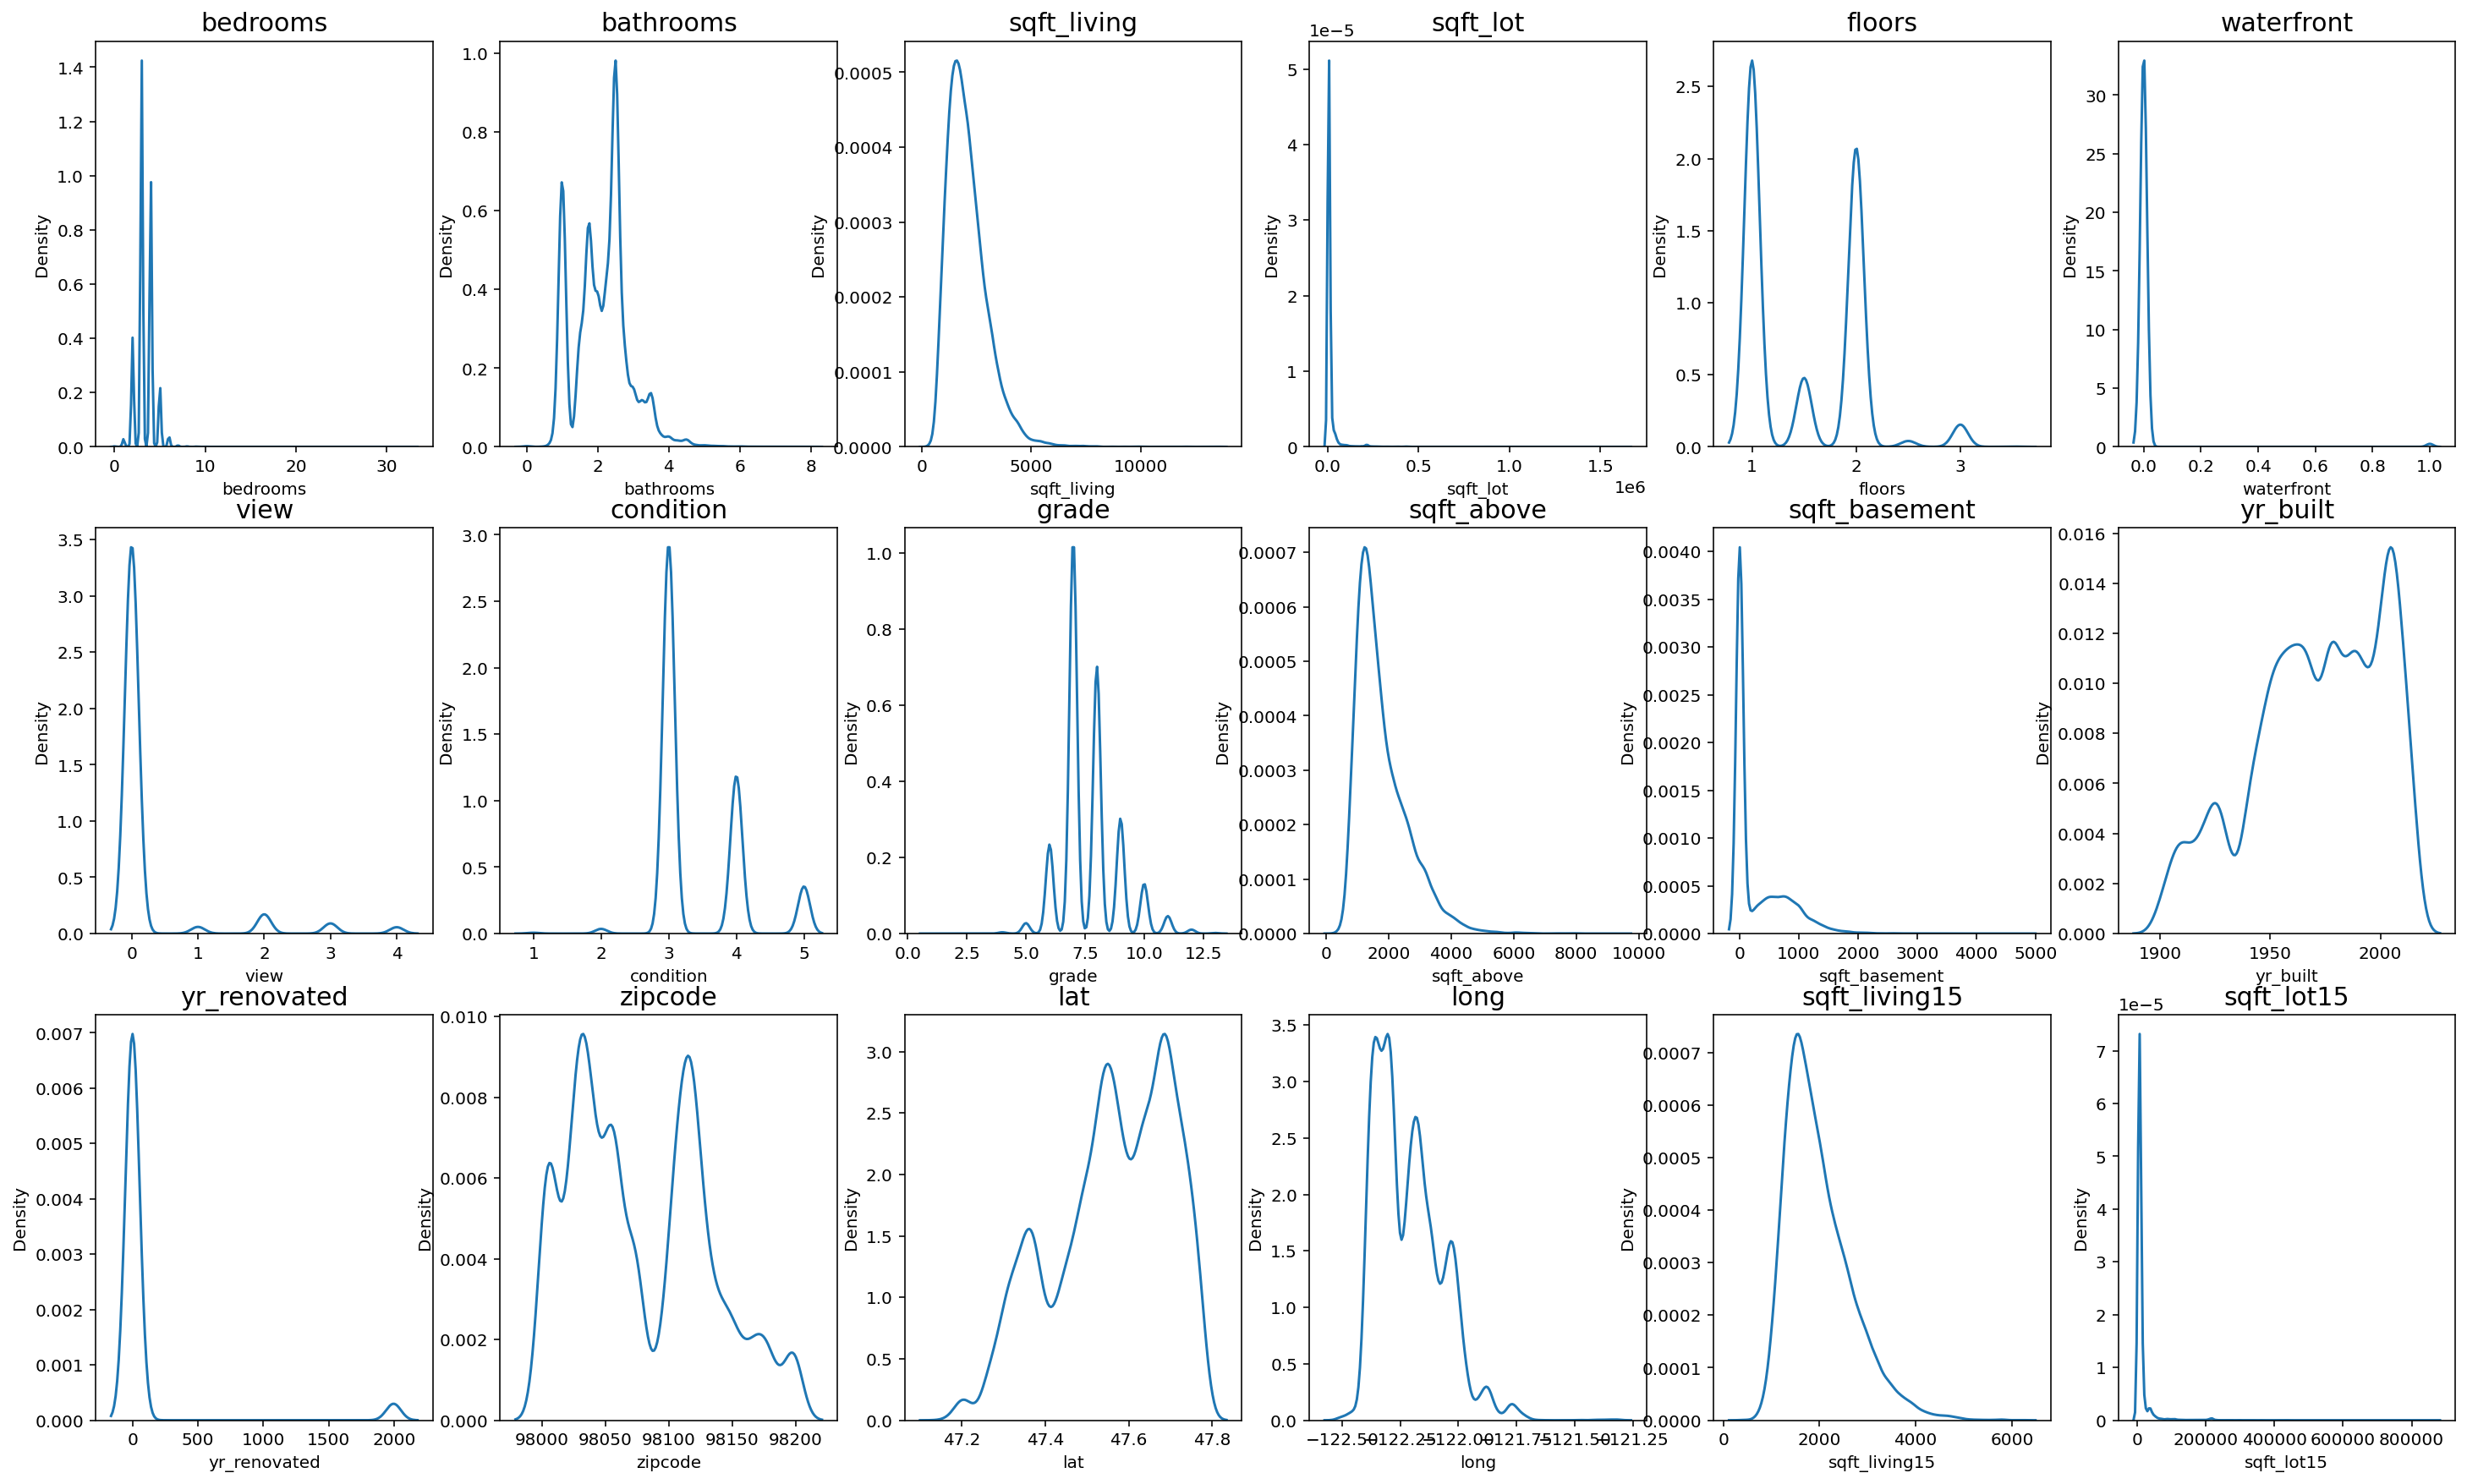

In [9]:
ig, ax = plt.subplots(3, 6, figsize=(25, 15))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = plus.columns
for row in range(3):
    for col in range(6):
        sns.kdeplot(data=plus[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

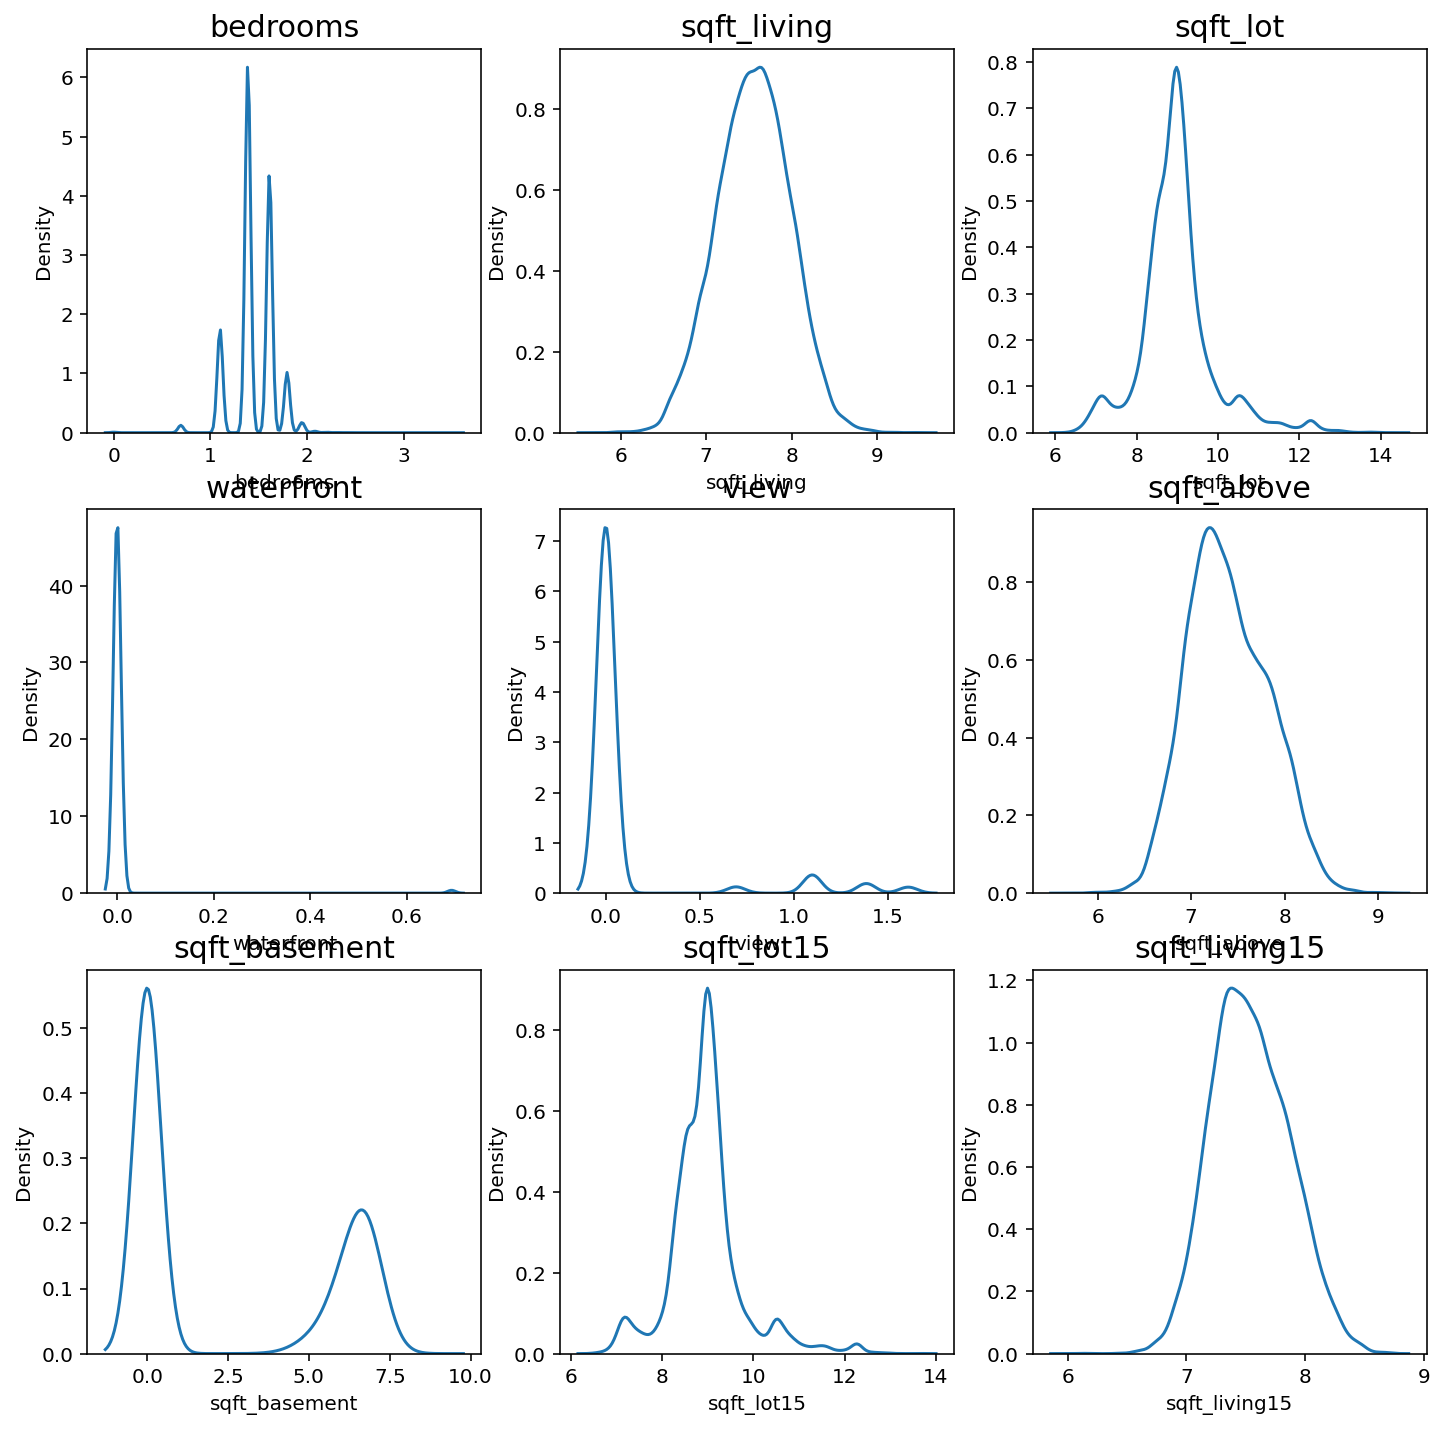

In [10]:
## 그래프 전처리
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    plus[c] = np.log1p(plus[c].values)

#재확인
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

count = 0
for row in range(3):
    for col in range(3):
        if count == 9:
            break
        sns.kdeplot(data=plus[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [11]:
#데이터 나누기

#test = plus.iloc[train_len:, :]
#x = plus.iloc[:train_len, :]

test = plus.iloc[train_len:, :]
train_data_path = plus.iloc[:train_len, :]

print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


In [15]:
#추가적으로 price 상관관계가 20%이하 변수 제거
#del train['condition']
#del test['condition']
#del train['long']
#del test['long']
#del train['sqft_lot15']
#del test['sqft_lot15']
#del train['yr_built']
#del test['yr_built']
#del train['sqft_lot']
#del test['sqft_lot']
del train['waterfront']
del test['waterfront']
#del train['yr_renovated']
#del test['yr_renovated']
del train['sqft_living']
del test['sqft_living']


print("불필요 변수 제거 완료!")

불필요 변수 제거 완료!


#**4. 모델링**
##(1) RMSE 계산

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('yea~')

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('드디어')

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('고지가')

# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2022        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
ada = AdaBoostRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest, ada]

print('눈 앞이야 엉엉😭')

yea~
드디어
고지가
눈 앞이야 엉엉😭


In [13]:
#이상치 제거 전
def get_scores(models, train, y):
    # 답안 작성
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=True)
            
    return score_df

get_scores(models, train, y)

[06:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
LGBMRegressor,122373.734476
GradientBoostingRegressor,129932.997074
XGBRegressor,130832.410523
RandomForestRegressor,135853.515325
AdaBoostRegressor,197199.430545


In [21]:
#이상치 제거 후

def get_scores(models, train, y):
    # 답안 작성
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=True)
            
    return score_df

get_scores(models, train, y)

[03:13:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
LGBMRegressor,114400.175131
RandomForestRegressor,135946.988689
XGBRegressor,138739.504845
GradientBoostingRegressor,139010.625138
AdaBoostRegressor,201923.376931


In [20]:
#이상치 제거 + 불필요 변수 제거

def get_scores(models, train, y):
    # 답안 작성
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=True)
            
    return score_df

get_scores(models, train, y)

[05:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
LGBMRegressor,123938.461035
GradientBoostingRegressor,145045.993999
XGBRegressor,145266.329825
RandomForestRegressor,145408.202342
AdaBoostRegressor,208512.567363


#❗생각❗
매우 좋은 발견이다!!!    
이상치 제거 전과 제거 후의 RMSE 값이 다르다.   
확실히 이상치 제거 후가 좀 더 높은 정확도를 줄 것 같다.   
뿐만 아니라 모델 순서도 달라졌다.

<이상치 제거 전>   
- RMSE 값이 낮은 순서(=성능 좋은 순서): LGBMRegressor < GradientBoostingRegressor < XGBRegressor < RandomForestRegressor < AdaBoostRegressor
- 사용할 모델: LGBMRegressor, GradientBoostingRegressor, XGBRegressor

<이상치 제거 후>
- RMSE 값이 낮은 순서(=성능 좋은 순서): LGBMRegressor < RandomForestRegressor < XGBRegressor < GradientBoostingRegressor < AdaBoostRegressor
- 사용할 모델: LGBMRegressor, RandomForestRegressor


이상치 제거 후 RandomForestRegressor의 순위가 높아지긴 했지만 RMSE로 보자면 흠 ...글쎄   
**이상치 제거가 LGBMRegressor에 영향을 준다는 사실은 분명한 것 같다.**

##(2) 그리드 탐색
-  model, param_grid와 함께 다른 여러 가지 인자를 넣어서 GridSearchCV를 수행할 수 있음

In [29]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""
from sklearn.model_selection import GridSearchCV


def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

print('OK')

OK


##LightGBM

In [50]:
param_grid = {
    'n_estimators': [250, 300, 350],
    'max_depth': [10, 15],
#    'learning_rate': [ None, 0.001 ],
    'num_leaves' : [30, 40],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
8,NaN,15,300,30,-0.026190,0.161835
6,NaN,15,250,30,-0.026208,0.161890
10,NaN,15,350,30,-0.026213,0.161904
0,NaN,10,250,30,-0.026214,0.161909
2,NaN,10,300,30,-0.026223,0.161936
4,NaN,10,350,30,-0.026255,0.162033
3,NaN,10,300,40,-0.026286,0.162131
5,NaN,10,350,40,-0.026323,0.162244
1,NaN,10,250,40,-0.026326,0.162253
7,NaN,15,250,40,-0.026519,0.162846


In [51]:
# LGBMRegressor 모델 학습
model = LGBMRegressor(max_depth=15, n_estimators=300, num_leaves=30, random_state=random_state)
model.fit(train, y)

# 예측값 저장
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 500724.03629636,  471037.93406509, 1441910.00179375, ...,
        468899.20954791,  327743.19323522,  449995.55616892])

In [16]:
#이상치 제거 전
param_grid = {
    'max_depth': [1, 5, 10],
    'n_estimators': [50, 100],
    'learning_rate': [ 0.03, 0.05 ],
    'num_leaves' : [15, 30],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
23,0.05,10,100,30,-0.029207,0.170899
19,0.05,5,100,30,-0.031459,0.177367
22,0.05,10,100,15,-0.031782,0.178276
18,0.05,5,100,15,-0.033044,0.181781
11,0.03,10,100,30,-0.034231,0.185015
7,0.03,5,100,30,-0.036523,0.191110
21,0.05,10,50,30,-0.037501,0.193652
10,0.03,10,100,15,-0.039044,0.197595
6,0.03,5,100,15,-0.039504,0.198757
17,0.05,5,50,30,-0.039867,0.199667


In [30]:
#너무 오래 걸려서 포기
#params = {
#     'num_leaves' : [15, 30],
#    'max_depth': [5, 10, 15, 20],
#    'n_estimators':[800, 900, 1000],
#    'min_data_in_leaf' : [5, 10, 25, 50],
#    'learning_rate': [ 0.03, 0.05, 0.07, 0.09]
#    'boosting_type' : ['gbdt', 'dart','goss','rf']    
#}

#model = LGBMRegressor(random_state=random_state)
#my_GridSearch(model, train, y, params, verbose=2, n_jobs=5)

param_grid = {
    'max_depth': [1, 5, 10],
    'n_estimators': [50, 100],
    'learning_rate': [ 0.03, 0.05 ],
    'num_leaves' : [15, 30],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
23,0.05,10,100,30,-0.030210,0.173810
19,0.05,5,100,30,-0.032434,0.180095
22,0.05,10,100,15,-0.032956,0.181538
18,0.05,5,100,15,-0.033705,0.183590
11,0.03,10,100,30,-0.035741,0.189053
7,0.03,5,100,30,-0.038025,0.195001
21,0.05,10,50,30,-0.039218,0.198036
10,0.03,10,100,15,-0.040906,0.202251
6,0.03,5,100,15,-0.041382,0.203426
17,0.05,5,50,30,-0.041545,0.203826


##(2) 랜덤서치
- 그리드 탐색을 했을 때 시간이 너무 오래 걸림
- 그리트 탐색시 하이퍼 파라미터 지정을 해줘야하는데 적당한 수를 지정한지 잘 모르겠음
- 검색을 해보니 이와 같은 이유로 랜덤서치가 효율적이라고 한다.
- 실제로 랜덤서치의 성능이 더 높다는 것이 입증되었는데 관련 논문은 아래에 링크 남겨두겠다.
- [랜덤서치의 성능](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)

In [40]:
#RandomizedSearchCV 클래스 import
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 

def my_RanSearch(model, train, y, params, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    Ransearch_model =  RandomizedSearchCV(model, params, random_state=200, cv=2, n_iter=25, scoring='neg_mean_squared_error',n_jobs=n_jobs)

    # 모델 fitting
    Ransearch_model.fit(train, y)

    # 결과값 저장
    params = Ransearch_model.cv_results_['params']
    score = Ransearch_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
params = {

    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [4,8,16,32], 
    'num_leaves' :[4,8,16,32],
    'min_child_samples' : [4,8,16,32], 
}

model = LGBMRegressor(random_state=random_state)
ran_search = my_RanSearch(model, train, y, params, verbose=2, n_jobs=5)

In [ ]:
ada_param_grid = {
    'n_estimators':[100, 200, 500, 1000],
    'loss':['linear', 'square', 'exponential'],
    'learning_rate' : [0.001, 0.001, 0.1, 1]    
}

In [ ]:
lgb_param_grid = {
#     'max_depth' : [None, 10, 20, 30, 50],
#     'learning_rate' : [0.001, 0.001, 0.1, 1]   ,
    'n_estimators':[100, 200, 500, 1000],
    'num_leaves' : [10, 20, 30],
    'boosting_type' : ['gbdt', 'dart','goss','rf']    
}

##RandomForest

In [43]:
#params = {
#    'n_estimators' : [100, 200, 500, 1000],
#     'max_depth' : [None, 10, 20, 30, 50],
#}
params = { 'n_estimators' : [500, 1000],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

model = RandomForestRegressor(random_state=random_state)
my_RanSearch(model, train, y, params, verbose=2, n_jobs=5)

,n_estimators,min_samples_split,min_samples_leaf,max_depth,score,RMSLE
11,500,8,8,12,-0.037012,0.192386
2,1000,16,8,10,-0.038051,0.195066
22,500,8,8,10,-0.038059,0.195088
18,1000,20,8,10,-0.038238,0.195545
21,1000,20,12,12,-0.038542,0.196320
15,1000,8,12,12,-0.038542,0.196320
7,500,20,12,12,-0.038550,0.196342
0,1000,20,12,10,-0.039311,0.198271
23,1000,8,18,12,-0.040607,0.201511
12,1000,8,18,10,-0.041078,0.202677


##LightGBM
<장점>   
- 빠른 학습 및 예측 수행 시간
- 더 작은 메모리 사용량
- 카테코리형 피처의 자동 변환 및 최적 분할

<주요 파라미터>
- num_iteration [default=100] : 반복 수행하기 위한 트리의 개수 지정. 크게 지정할수록 예측 성능이 높아질 수 있지만 과적합 문제 가능성 또한 높아짐.
- learning_rate [default=0.1] : 0~1 사이의 값을 지정해 부스팅 스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값. 일반적으로 n_estimators를 크게하고 - learning_rate을 작게 해서 예측 성능 향상 가능, 과적합 이슈 동반.
- max_depth [default=-1]: 0보다 작은 값을 지정하면 깊이에 제한 없음.
- min_data_in_leaf [default=20] : 결정 트리의 min_samples_leaf와 동일. 최종 결정 클래스인 리프 노드가 되기 위해 최소한으로 필요한 레코드 수. (과적합 방지용)
- num_leaves [default=32] : 하나의 트리가 가질 수 있는 최대 리프 수
- boosting [default=gbdt] : 부스팅 트리를 생성하는 알고리즘 (gbdt:일반적인 그래디언트 부스팅, rf:랜덤포레스트)
- bagging_fraction [default=1.0] : 트리가 커져서 과적합 되는 것을 방지하기 위한 데이터 샘플링 비율.
- feature_fraction [default=1.0] : 개별 트리를 학습할 때 무작위로 선택되는 피처의 비율 (GBM의 max_features와 동일)
- lambda_I2 [default=0.0] : L2 regulation 제어를 위한 값. 피처 개수가 많을 경우 적용 검토. 값이 클수록 과적합 감소 효과
- lambda_I1[default=0.0] : L1 regulation 제어를 위한 값. 과적합 방지용.

<튜닝 방안>   
- num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하는 것이 모델의 복잡도를 줄이는 가장 기본적인 튜닝 방식입니다.

###이상치 제거 전

In [54]:
#params = {
#
#    'n_estimators': [900, 1000],
#    'max_depth': [11, 13, 15],
#    'num_leaves': [15, 31],
#    'learning_rate': [0.01, 0.03, 0.05]
#}

#model = LGBMRegressor(random_state=random_state)
#my_RanSearch(model, train, y, params, verbose=2, n_jobs=5)

,num_leaves,n_estimators,max_depth,learning_rate,score,RMSLE
11,15,900,11,0.05,-0.027230,0.165016
0,15,900,15,0.05,-0.027358,0.165403
17,15,1000,15,0.03,-0.027390,0.165499
12,15,1000,13,0.03,-0.027390,0.165499
2,15,1000,15,0.05,-0.027406,0.165549
15,31,900,15,0.03,-0.027456,0.165697
6,31,1000,15,0.03,-0.027460,0.165710
4,15,900,15,0.03,-0.027494,0.165814
1,31,900,13,0.03,-0.027528,0.165914
20,31,1000,13,0.03,-0.027534,0.165934


- num_leaves : 작을 수록 유리하다.
- max_depth : 큰 값들은 하단에 위치해서 작은 값을 세분화
- learning_rate : 여러 번 실험을 통해 해당 파라미터가 굉장히 중요함을 알아냄


In [32]:
params = {
     'num_leaves' : [15, 30],
    'max_depth': [5, 10, 15, 20],
    'n_estimators':[800, 900, 1000],
    'min_data_in_leaf' : [5, 10, 25, 50],
    'learning_rate': [ 0.03, 0.05, 0.07, 0.09]
#    'boosting_type' : ['gbdt', 'dart','goss','rf']    
}

model = LGBMRegressor(random_state=random_state)
my_RanSearch(model, train, y, params, verbose=2, n_jobs=5)

,num_leaves,n_estimators,min_data_in_leaf,max_depth,learning_rate,score,RMSLE
11,15,800,25,15,0.05,-0.027164,0.164814
20,15,900,25,20,0.03,-0.027297,0.165219
15,15,1000,25,5,0.03,-0.027332,0.165325
16,15,900,25,20,0.07,-0.027392,0.165505
5,15,1000,50,10,0.05,-0.027393,0.165509
10,15,900,25,5,0.07,-0.027481,0.165774
22,15,900,50,10,0.07,-0.027620,0.166193
12,15,800,10,5,0.07,-0.027669,0.166340
7,30,800,5,15,0.03,-0.027692,0.166409
1,15,1000,10,15,0.03,-0.027720,0.166492


###이상치 제거 후

In [36]:
params = {
    'max_depth': [1, 5, 10],
    'n_estimators': [50, 100],
    'learning_rate': [ 0.03, 0.05 ],
    'num_leaves' : [15, 30], 
}

model = LGBMRegressor(random_state=random_state)
my_RanSearch(model, train, y, params, verbose=2, n_jobs=5)

,num_leaves,n_estimators,max_depth,learning_rate,score,RMSLE
23,30,100,10,0.05,-0.030977,0.176003
19,30,100,5,0.05,-0.032929,0.181464
22,15,100,10,0.05,-0.033414,0.182794
18,15,100,5,0.05,-0.034028,0.184466
11,30,100,10,0.03,-0.036102,0.190005
7,30,100,5,0.03,-0.038433,0.196043
21,30,50,10,0.05,-0.039559,0.198895
10,15,100,10,0.03,-0.040944,0.202347
6,15,100,5,0.03,-0.041501,0.203717
17,30,50,5,0.05,-0.041858,0.204593


In [37]:
# LGBMRegressor 모델 학습
model = LGBMRegressor(num_leaves=30, n_estimators=100, max_depth=10, learning_rate=0.05, random_state=random_state)
model.fit(train, y)

# 예측값 저장
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([271385.13326362, 329639.91711794, 670115.89816444, ...,
       351864.42302692, 286134.07275443, 290286.74473136])

In [52]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '/content/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [53]:
#한 줄 저장!
save_submission(model, train, y, test, 'lgbm', rmsle='	0.161835')

/content/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_	0.161835.csv saved!


#**5. 제출 결과 Score**
##9번째인지 10번째인지 결과
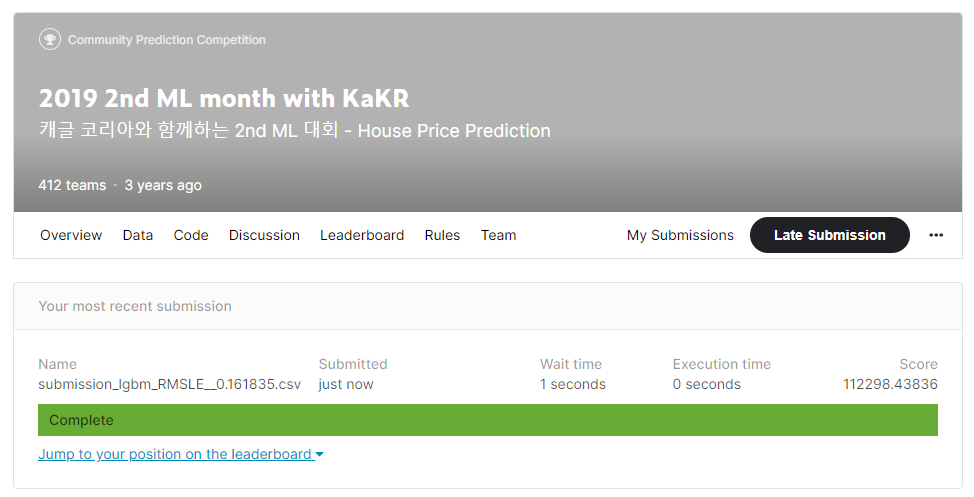



---


#**6. 🤔 회고** 🤔

## <이번 프로젝트에서 **어려웠던 점**>
###**🤷‍♀️18시간 동안 열심히 이상치 제거했는데 제출하니 점수에 변동이 없었던 것............^-^🤷‍♀️**

(1) Colab에서의 Conda 사용법

(2) EDA를 하면서 난 수많은 오류들....ㅠ
- AttributeError: module 'nltk' has no attribute 'data'
pandas Profiling

- EDA 데이터 탐색하기 : Cleaning and organizing data 와 Collecting data sets 처리에 거의 80% 걸림

- 판다스 프로파일링을 위한 설치    
<명령어 뜯어보기>
pip install [설치]   
\-U [최신버전 Update?]   
pip install -U pandas_profiling   
import pandas as pd   
import pandas_profiling   
    
(3) 그놈의!!!!!!!! 오류!!!!!!!!!!!!!!!!!!!!!1
- 이상치 제거하면 오류 나고..   
- 제거해서 데이터셋 나누니 NaN 때문에 오류나고....
- 오류의 연속은 5일 동안 했지만 여전히 빠져나오지 못했다.....    

    
## <프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.>
(1) Cross Validation 과정에서의 오류   
 WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror. 라는 오류가 발생

(2) 파라미터와 하이퍼파라미터 
- 파라미터 : 모델 내부에서 결정되는 변수로 그 값은 데이터로부터 결정된다.
- 하이퍼파라미터 : 모델링할 때 사용자가 직접 세팅해주는 값을 뜻한다.   

(3) RMSE이란?
-  평균 제곱근 오차(Root Mean Square Error; RMSE)로 추정 값 또는 모델이 예측한 값과 실제 환경에서 관찰되는 값의 차이를 다룰 때 쓰는 측도이다.

(4) GridSearchCV와 Random Search
- 그리드 탐색 : 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색함. 따라서 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리   
정해둔 공간에서만 탐색하기 때문에 최적의 조합을 놓칠 수 있음
- 랜덤 탐색 : 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법   
 최적의 조합을 찾을 수 있는 가능성이 있으나 언제나 최적의 조합을 찾는 것은 아님
<img src="https://d3s0tskafalll9.cloudfront.net/media/images/E10-13.max-800x600.png" width="" height=""  title="px(픽셀) 크기 설정" alt="터미널"></img><br/>

(5) 파이썬 데이터 시각화   
- 시각화하는데 정말 다양한 그래프가 있다는 것을 알았다.
- 각 그래프들은 필요 정보에 따라 알맞은 모양이 있는데 이를 위해 좀 더 공부하는 것이 좋을 것 같다.

(6) Heatmap 데이터 시각화   
- Heatmap 시각화에는 2가지 방법이 있다.   
- 하나는 Matplotlib를 이용하는 것이고, 하나는 seaborn을 이용하는 것인데   
seaborn을 이용하는 것이 훨씬 간결하게 나타낼 수 있다.   
- 처음에는 Matplotlib를 사용하였는데 크기를 크게 조절해주어도 그래프가 뭉개지는 현상이 보였다.   
그래서 seaborn 으로 수정하였더니 훨씬 깔끔하고 수치도 눈에 잘 들어왔다.   
그래서 이번 캐글에서는 seaborn 으로 heatmap 시각화를 진행하였다.
- resize 하는 방법
  - seaborn : sns.set(rc = {'figure.figsize':(25,25)})
  - Matplotlib: plt.figure(figsize = (15,8))   

처음에 전체 데이터 시각화 할 때 resize 했다가 상위 10개만 추출하면서 resize가 필요없어 지움.

(7) 이상치란?
- 관측된 데이터의 범위에서 많이 벗어난 아주 작은 값이나 아주 큰 값을 말함
- 이상치 계산법은 따로 아래 링크로 걸어두겠다.

(8)내림차순, 오름차순 정렬하는 방법    
sort_values( ) 를 사용한다.    
- 오름차순 : ascending = True 또는 생략
- 내림차순 : ascending = False
    
.    
    
## <루브릭 평가 지표를 맞추기 위해 **시도한 것들**.>
(1) 우선 Price에 영향을 많이 주는 요소들을 찾고 싶었다.   
  처음부터 간단하게 하이퍼파라미터를 튜닝할 수 있겠었지만, LMS 5-13 상단에 나와 있는 **'예를 들면 가장 기본적으로는 데이터를 깊게 탐색하는 EDA 과정을 통해 불필요한 피처를 골라내거나 적절하게 피처를 수정하는 등의 피처 엔지니어링을 진행함으로써 데이터를 정제하는 것이 매우 중요합니다.'** 라는 문장을 보고 정석대로 한 번 시도해보고 싶었다. 

(2) EDA 수행을 위해 dataprap 설치 등을 시도하였으나 계속되는 시스템 충돌 오류로 인해 다른 방법을 찾아보았더니 heatmap으로 상관관계 파악하는 방법을 알게 되었다.   

(3) 히트맵을 통해 price에 영향을 주는 상위 5개 지표들을 찾아 그래프화한 후 일정 범위 이상을 넘어서는 값을들 지우고자 한다. 이를 이상치 측정 및 삭제라고 하더라.   

(4) 하이퍼파라미터 튜닝을 위해 각 모델별 파라미터와 어떤 파라미터 위주로 튜닝되는지 찾아보았다. 튜닝을 통해 분명 더 낮은 RMSLE 값을 얻었음에도 score은 계속 내려간다........ 왜?????!?!?
    
.    
    
##<만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.>
 데이터 정제하는 과정에서 하고 싶었지만 아직 알고 있는 개념이 많이 없어 시행하지 못한 부분들도 있다. 전반적으로 좀 더 효율적으로 진행할 수 있는 부분들이 있을 것 같은데 상당히 비효율적으로 진행하면서 평가 지표에 도달하지 못한 것 같다..ㅠ 
    
.    
    
## <**자기 다짐**>
#👍교훈 : 실력이 없으면 객기 부리지 말자!👍
일단 주말 이틀 연속으로 새벽 5시까지 만지다보니....   
###하........괜한 짓을 한 것 같다...... 뭐하러....이상치를 제거한다고 한지 모르겠다...........ㅠㅠ   
ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...   
그래도 덕분에 뭔갈 많이 얻어간 것 같다...   
앞으론 욕심 부리지 말아야겠다...!   
내가 배운 범위 내에서 해결하도록 노력해야겠다.........

#**7. Reference**
1. https://towardsdatascience.com/conda-google-colab-75f7c867a522
2. https://velog.io/@sossont/EDA-%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%9D%84-%ED%99%9C%EC%9A%A9%ED%95%9C-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B6%84%EC%84%9D%ED%95%98%EA%B8%B0Pandas
3. https://pypi.org/project/dataprep/
4. https://docs.python.org/3/tutorial/venv.html
5. https://docs.dataprep.ai/user_guide/eda/introduction.html
6. https://aimb.tistory.com/179 가상환경... 왜 해결이 안되죠?ㅠㅠ
7. 파이썬 데이터 시각화 : https://youngwonhan-family.tistory.com/62
8. 그래프 종류 : http://growthj.link/python-seaborn-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%8B%9C%EA%B0%81%ED%99%94-%EC%B4%9D%EC%A0%95%EB%A6%AC/
9. 이상치에 대해 : http://www.databaser.net/moniwiki/wiki.php/%EC%9D%B4%EC%83%81%EC%B9%98%EC%A0%9C%EA%B1%B0%EB%B0%A9%EB%B2%95
